# Regression Prix Immobilier

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd


pd.set_option('display.max_columns', 5000)
pd.set_option("display.max_rows", 101)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

In [2]:
import warnings

from sklearn.model_selection import train_test_split


# Load configuration
# sys.path.append("../")
warnings.filterwarnings("ignore")

from utils import RANDOM_STATE, TEST_SIZE, TARGET, ALPHA

# Load the data
X = pd.read_csv("./data/kaggle_train_set.csv")

train, test = train_test_split(
    X, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

print(f"The train set contains: {train.shape} elements")
print(f"The test set contains: {test.shape} elements")

train.head()

The train set contains: (944, 16) elements
The test set contains: (236, 16) elements


,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,KitchenQual,Fireplaces,LotArea,Neighborhood,ExterQual,SalePrice
689,5,1701,1390,1701,1975,1981,2,611,2,6,TA,2,16647,Sawyer,TA,171000
597,7,1728,864,864,2004,2004,2,572,2,7,Gd,0,9313,CollgCr,Gd,190000
45,10,2945,1410,1426,2006,2006,3,641,3,10,Gd,1,13682,StoneBr,Ex,438780
418,7,2344,1264,1277,1996,1997,3,889,2,7,Gd,1,10208,NoRidge,Gd,265000
247,5,1118,793,793,1939,1950,2,410,1,5,TA,1,7800,OldTown,TA,119900


## Analyse de forme

In [3]:
if duplicated := train.duplicated().any():
    print("Il y a des lignes dupliqués. On les supprimes.")
    train.drop_duplicates(keep='first', inplace=True)
    train.head()
    print(f"Nouvelle shape du train set: {train.shape}")
else:
    print("Il n´y a pas de lignes dupliqués.")


Il n´y a pas de lignes dupliqués.


In [4]:
print(train.dtypes.value_counts())
train.info()

int64     13
object     3
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 944 entries, 689 to 684
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   OverallQual   944 non-null    int64 
 1   GrLivArea     944 non-null    int64 
 2   TotalBsmtSF   944 non-null    int64 
 3   1stFlrSF      944 non-null    int64 
 4   YearBuilt     944 non-null    int64 
 5   YearRemodAdd  944 non-null    int64 
 6   GarageCars    944 non-null    int64 
 7   GarageArea    944 non-null    int64 
 8   FullBath      944 non-null    int64 
 9   TotRmsAbvGrd  944 non-null    int64 
 10  KitchenQual   944 non-null    object
 11  Fireplaces    944 non-null    int64 
 12  LotArea       944 non-null    int64 
 13  Neighborhood  944 non-null    object
 14  ExterQual     944 non-null    object
 15  SalePrice     944 non-null    int64 
dtypes: int64(13), object(3)
memory usage: 125.4+ KB


In [5]:
print("Recherche des colonnes contenant des valeurs manquantes")
print(train.isna().any())

Recherche des colonnes contenant des valeurs manquantes
OverallQual     False
GrLivArea       False
TotalBsmtSF     False
1stFlrSF        False
YearBuilt       False
YearRemodAdd    False
GarageCars      False
GarageArea      False
FullBath        False
TotRmsAbvGrd    False
KitchenQual     False
Fireplaces      False
LotArea         False
Neighborhood    False
ExterQual       False
SalePrice       False
dtype: bool


In [6]:
print("Recherche des colonnes contenant des valeurs nulles")
print(train.isnull().any())

Recherche des colonnes contenant des valeurs nulles
OverallQual     False
GrLivArea       False
TotalBsmtSF     False
1stFlrSF        False
YearBuilt       False
YearRemodAdd    False
GarageCars      False
GarageArea      False
FullBath        False
TotRmsAbvGrd    False
KitchenQual     False
Fireplaces      False
LotArea         False
Neighborhood    False
ExterQual       False
SalePrice       False
dtype: bool


In [7]:
train.describe()

,OverallQual,GrLivArea,TotalBsmtSF,1stFlrSF,YearBuilt,YearRemodAdd,GarageCars,GarageArea,FullBath,TotRmsAbvGrd,Fireplaces,LotArea,SalePrice
count,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00
mean,6.13,1517.72,1067.70,1165.78,1971.30,1984.98,1.76,471.83,1.56,6.51,0.62,10533.39,180989.79
std,1.38,537.98,459.57,405.38,30.01,20.56,0.75,213.38,0.55,1.63,0.65,11040.77,80364.42
min,2.00,438.00,0.00,438.00,1875.00,1950.00,0.00,0.00,0.00,3.00,0.00,1300.00,34900.00
25%,5.00,1127.50,792.75,873.50,1954.00,1967.00,1.00,314.25,1.00,5.00,0.00,7500.00,129000.00
50%,6.00,1452.50,1004.00,1088.00,1972.00,1994.00,2.00,473.00,2.00,6.00,1.00,9496.00,162500.00
75%,7.00,1795.25,1314.50,1391.00,2000.00,2004.00,2.00,576.00,2.00,7.00,1.00,11616.00,213625.00
max,10.00,5642.00,6110.00,4692.00,2010.00,2010.00,4.00,1418.00,3.00,14.00,3.00,215245.00,755000.00


In [8]:
train.describe(include=['O'])

,KitchenQual,Neighborhood,ExterQual
count,944,944,944
unique,4,25,4
top,TA,NAmes,TA
freq,483,158,583


## Analyse de fond
### Visualisation de la target

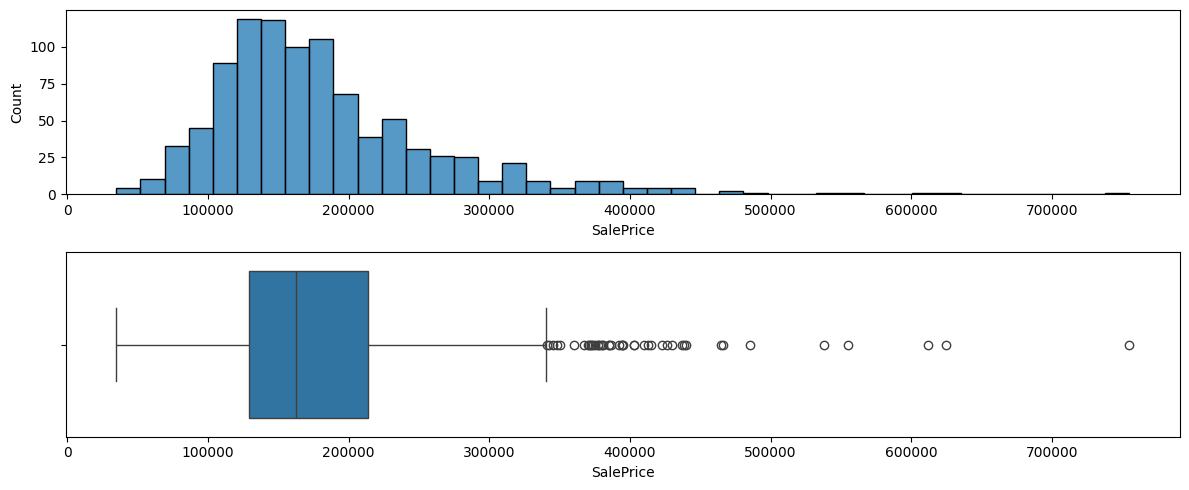

Skewness:  1.789
Kurtosis:  5.735


In [9]:
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 5))
sns.histplot(data=train, x='SalePrice', ax=ax1)
sns.boxplot(train, x='SalePrice', ax=ax2)
plt.tight_layout()
plt.show()

print('Skewness: ', round(stats.skew(train.SalePrice), 3))
print('Kurtosis: ', round(stats.kurtosis(train.SalePrice), 3))

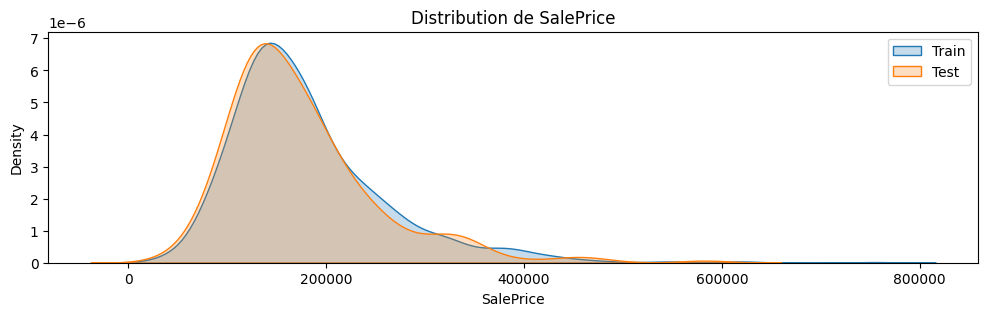

In [10]:
column = 'SalePrice'
# Visualisation des distributions
plt.figure(figsize=(12, 3))
sns.kdeplot(train[column], label='Train', shade=True)
sns.kdeplot(test[column], label='Test', shade=True)
plt.title(f"Distribution de {column}")
plt.legend()
plt.show()

**observation:** Répartition équilibré au niveau du train et test set
### Visualisation des variables

In [11]:
continuous_columns = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'LotArea']

discrete_columns = [col for col in train.columns if col not in continuous_columns]
for col in discrete_columns:
    if col != 'SalePrice':
        print(f"{col :-<30} {train[col].unique()}")

OverallQual------------------- [ 5  7 10  8  6  3  9  4  2]
YearBuilt--------------------- [1975 2004 2006 1996 1939 1972 2007 1925 1968 2005 1961 1966 1991 2000
 1978 1940 1995 2002 1905 1998 1969 1999 1970 1948 1979 1976 2003 1958
 1964 2010 1965 1949 1938 1923 2001 1950 1929 1955 1930 1952 1957 1992
 2008 1954 1935 1959 1982 1947 1945 1994 1956 1977 1960 1927 1980 1963
 1985 1973 1971 1984 1951 1967 1920 1962 1986 1932 1993 1916 1981 1921
 1924 1918 1880 1926 1931 1988 1928 1953 1989 2009 1910 1997 1922 1908
 1990 1915 1890 1941 1942 1900 1936 1974 1911 1983 1914 1917 1934 1912
 1913 1906 1946 1882 1885 1892 1875 1937]
YearRemodAdd------------------ [1981 2004 2006 1997 1950 1972 2007 1990 1968 2005 1961 1966 1992 2000
 1978 1996 2002 1998 1969 1999 2003 1995 1970 1979 1976 1958 1964 2010
 2009 2008 1974 1952 1989 1957 1954 1959 1982 1994 1965 1956 1977 1960
 1980 1988 1963 1985 1973 1971 1967 1975 1962 1987 1993 1955 1991 1984
 2001 1951 1983 1986 1953]
GarageCars------------------

#### OverallQual

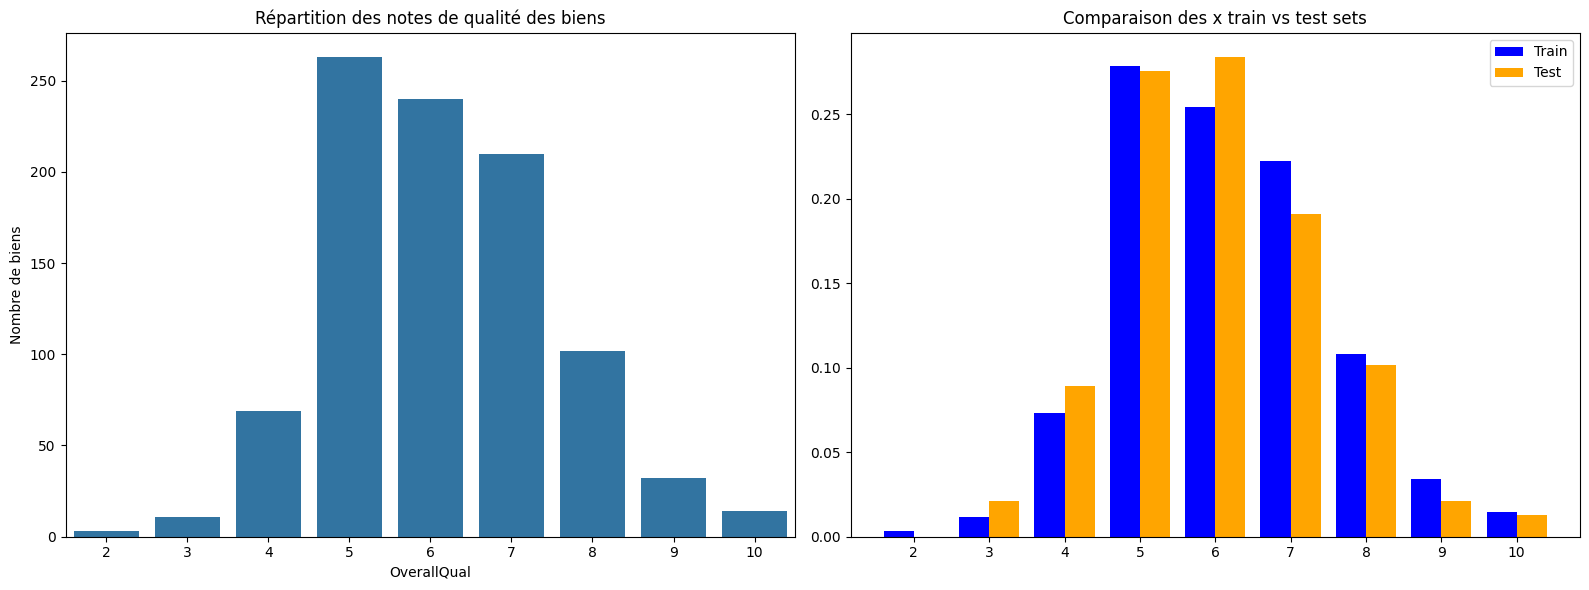

In [12]:
# Création d'une figure avec des subplots pour intégrer les deux graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique : Répartition des notes de qualité des biens
sns.countplot(data=train, x="OverallQual", ax=ax1)
ax1.set_title("Répartition des notes de qualité des biens")
ax1.set_xlabel("OverallQual")
ax1.set_ylabel("Nombre de biens")

# Deuxième graphique : Comparaison des distributions entre train et test
train_counts = train['OverallQual'].value_counts(normalize=True).sort_index()
test_counts = test['OverallQual'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

#### YearBuilt & YearRemodAdd

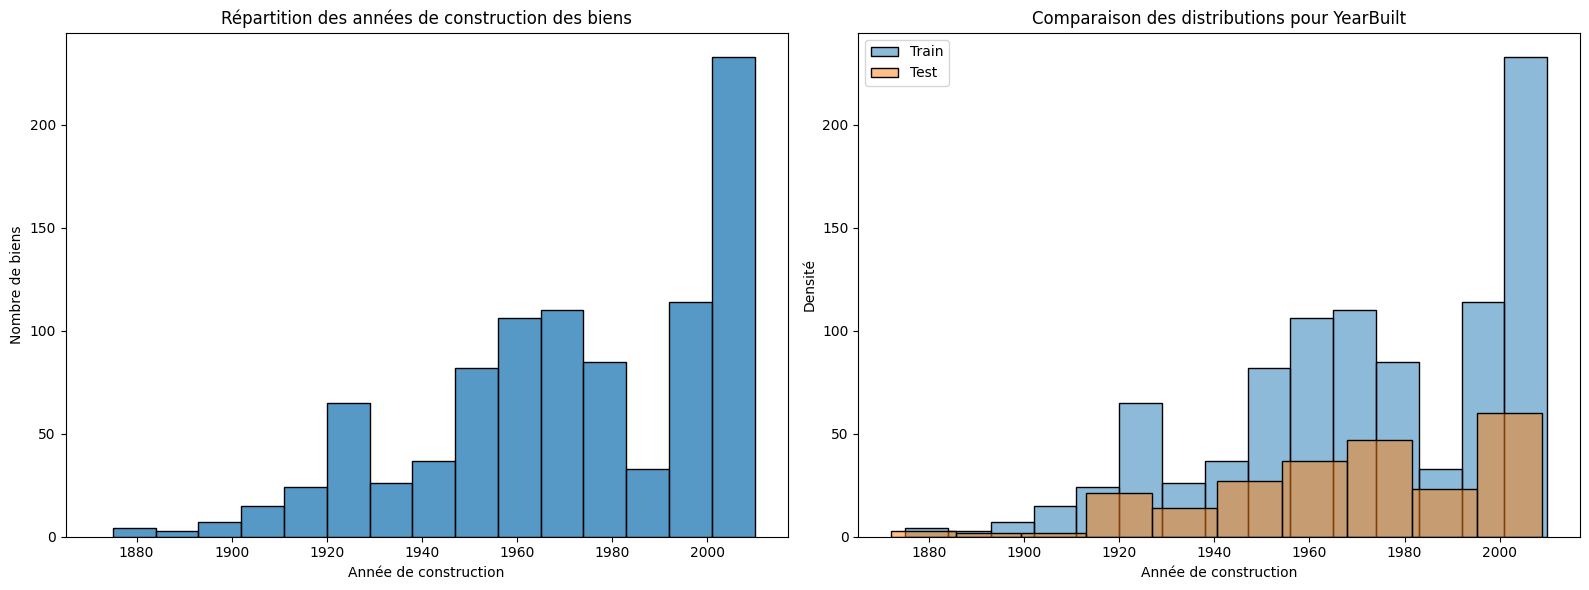

In [13]:
# Création d'une figure avec des subplots pour intégrer les deux graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Premier graphique : Répartition des années de construction des biens avec displot
sns.histplot(data=train, x="YearBuilt", kde=False, ax=ax1)
ax1.set_title("Répartition des années de construction des biens")
ax1.set_xlabel("Année de construction")
ax1.set_ylabel("Nombre de biens")

# Deuxième graphique : Comparaison des distributions entre train et test avec displot
sns.histplot(data=train, x="YearBuilt", label='Train', ax=ax2, alpha=0.5)
sns.histplot(data=test, x="YearBuilt", label='Test', ax=ax2, alpha=0.5)
ax2.set_title("Comparaison des distributions pour YearBuilt")
ax2.set_xlabel("Année de construction")
ax2.set_ylabel("Densité")
ax2.legend()

plt.tight_layout()
plt.show()

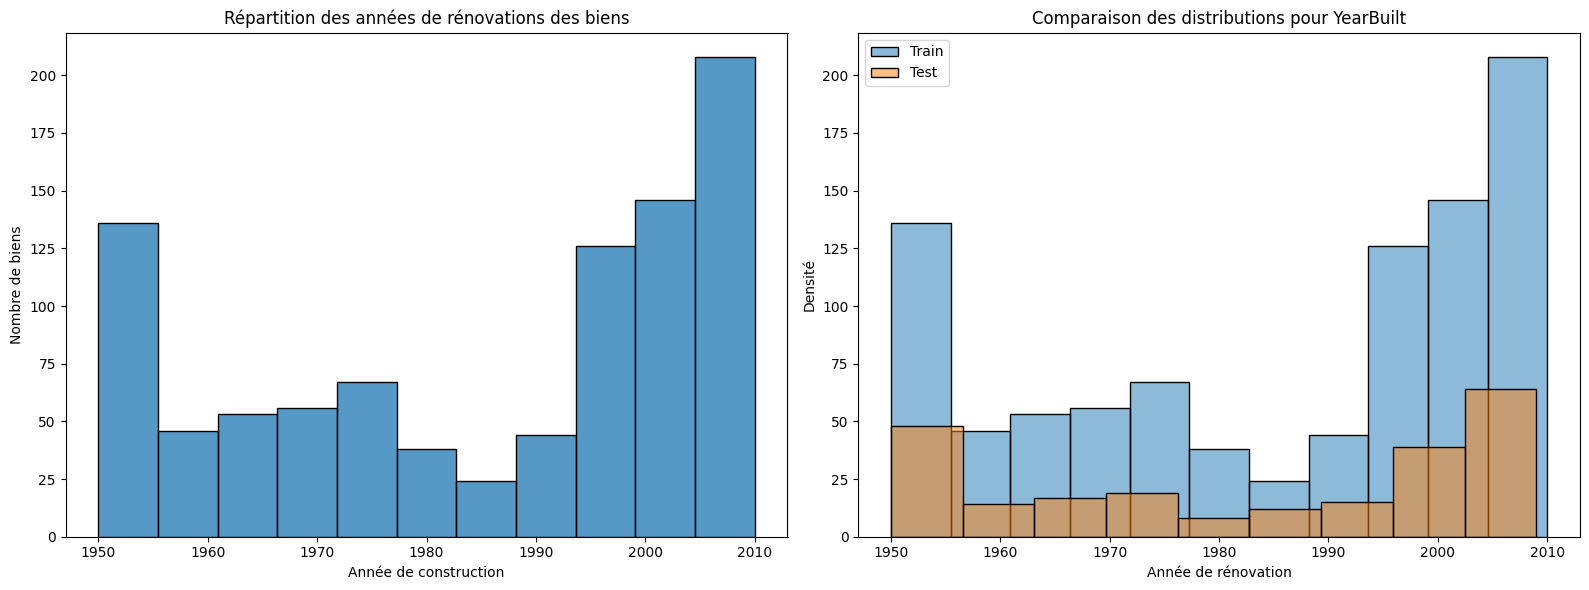

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

sns.histplot(data=train, x="YearRemodAdd", kde=False, ax=ax1)
ax1.set_title("Répartition des années de rénovations des biens")
ax1.set_xlabel("Année de construction")
ax1.set_ylabel("Nombre de biens")

sns.histplot(data=train, x="YearRemodAdd", label='Train', ax=ax2, alpha=0.5)
sns.histplot(data=test, x="YearRemodAdd", label='Test', ax=ax2, alpha=0.5)
ax2.set_title("Comparaison des distributions pour YearBuilt")
ax2.set_xlabel("Année de rénovation")
ax2.set_ylabel("Densité")
ax2.legend()

plt.tight_layout()
plt.show()

On cherche à quantifier le nombre de biens ayant subit une rénovation de ceux non rénové.

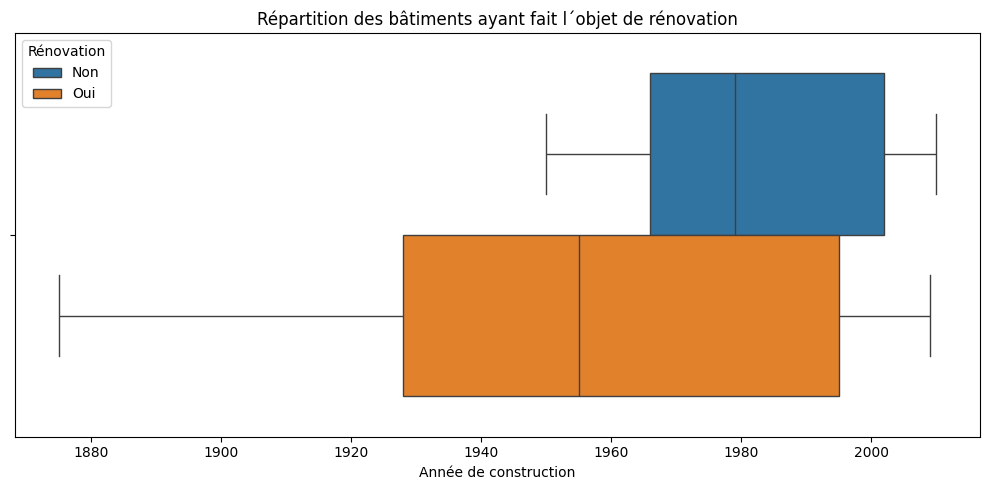

In [15]:
train['HasRemod'] = train.YearBuilt != train.YearRemodAdd
test['HasRemod'] = test.YearBuilt != test.YearRemodAdd

plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x="YearBuilt", hue="HasRemod")
plt.title("Répartition des bâtiments ayant fait l´objet de rénovation")
plt.xlabel("Année de construction")
plt.legend(
    title="Rénovation",
    labels=["Non", "Oui"],
)
plt.tight_layout()
plt.show()

In [16]:
print("Statistiques des biens rénovés :")
print(train[train['HasRemod'] == True]['YearBuilt'].describe())
print("\nStatistiques des biens non rénovés :")
print(train[train['HasRemod'] == False]['YearBuilt'].describe())

Statistiques des biens rénovés :
count    452.00
mean    1958.73
std       34.52
min     1875.00
25%     1928.00
50%     1955.00
75%     1995.00
max     2009.00
Name: YearBuilt, dtype: float64

Statistiques des biens non rénovés :
count    492.00
mean    1982.84
std       18.88
min     1950.00
25%     1966.00
50%     1979.00
75%     2002.00
max     2010.00
Name: YearBuilt, dtype: float64


In [17]:
train.columns

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt',
       'YearRemodAdd', 'GarageCars', 'GarageArea', 'FullBath', 'TotRmsAbvGrd',
       'KitchenQual', 'Fireplaces', 'LotArea', 'Neighborhood', 'ExterQual',
       'SalePrice', 'HasRemod'],
      dtype='object')

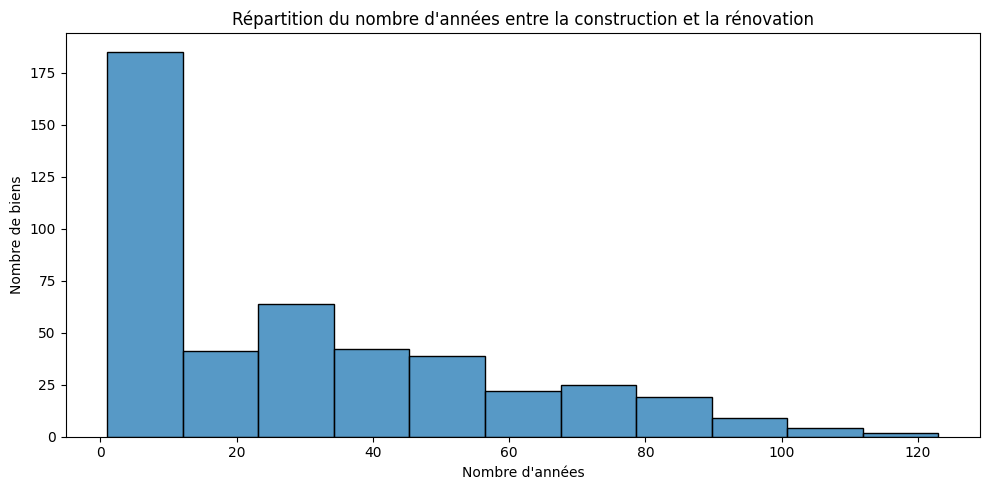

Statistiques descriptives du nombre d'années entre construction et rénovation pour les bâtiments rénovés :
count   452.00
mean     28.57
std      28.59
min       1.00
32%       1.00
33%       2.00
50%      23.50
75%      47.00
max     123.00
Name: YearToRemod, dtype: float64


In [18]:
# On ne s´intéresse qu´aux biens ayant subit une rénovation
train['YearToRemod'] = train.YearRemodAdd - train.YearBuilt

plt.figure(figsize=(10, 5))
sns.histplot(data=train[train['HasRemod'] == True], x='YearToRemod')
plt.title("Répartition du nombre d'années entre la construction et la rénovation")
plt.xlabel("Nombre d'années")
plt.ylabel("Nombre de biens")
plt.tight_layout()
plt.show()

print("Statistiques descriptives du nombre d'années entre construction et rénovation pour les bâtiments rénovés :")
print(train[train['HasRemod'] == True]['YearToRemod'].describe(percentiles=[0.32, 0.33, .5, .75]))

#### GarageCars

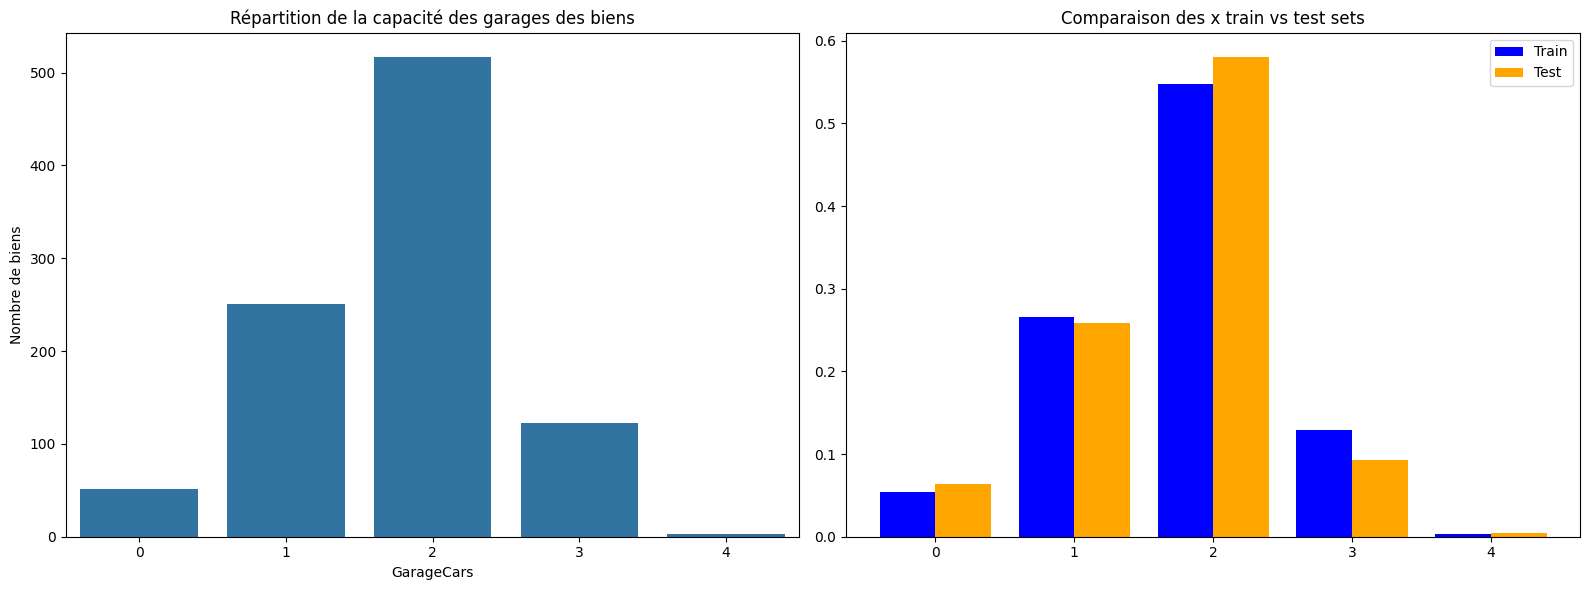

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=train, x="GarageCars", ax=ax1)
ax1.set_title("Répartition de la capacité des garages des biens")
ax1.set_xlabel("GarageCars")
ax1.set_ylabel("Nombre de biens")

# Deuxième graphique : Comparaison des distributions entre train et test
train_counts = train['GarageCars'].value_counts(normalize=True).sort_index()
test_counts = test['GarageCars'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

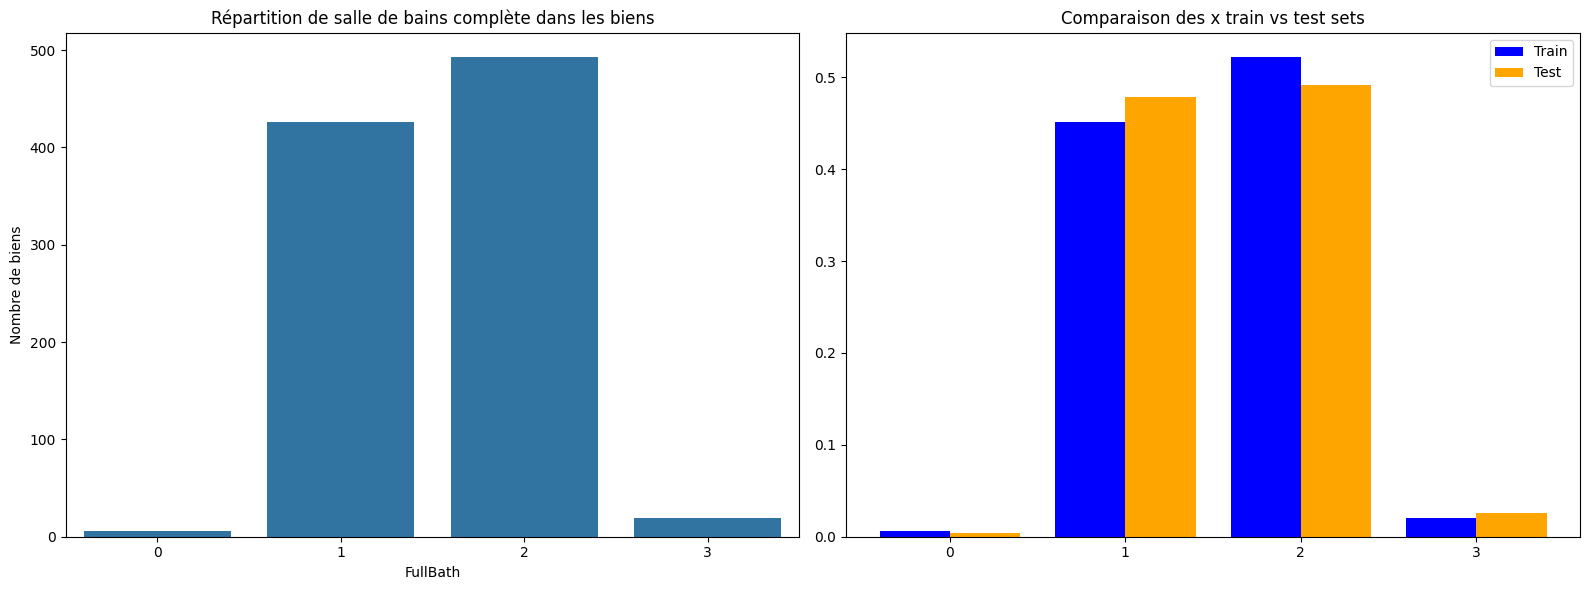

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=train, x="FullBath", ax=ax1)
ax1.set_title("Répartition de salle de bains complète dans les biens")
ax1.set_xlabel("FullBath")
ax1.set_ylabel("Nombre de biens")

# Deuxième graphique : Comparaison des distributions entre train et test
train_counts = train['FullBath'].value_counts(normalize=True).sort_index()
test_counts = test['FullBath'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

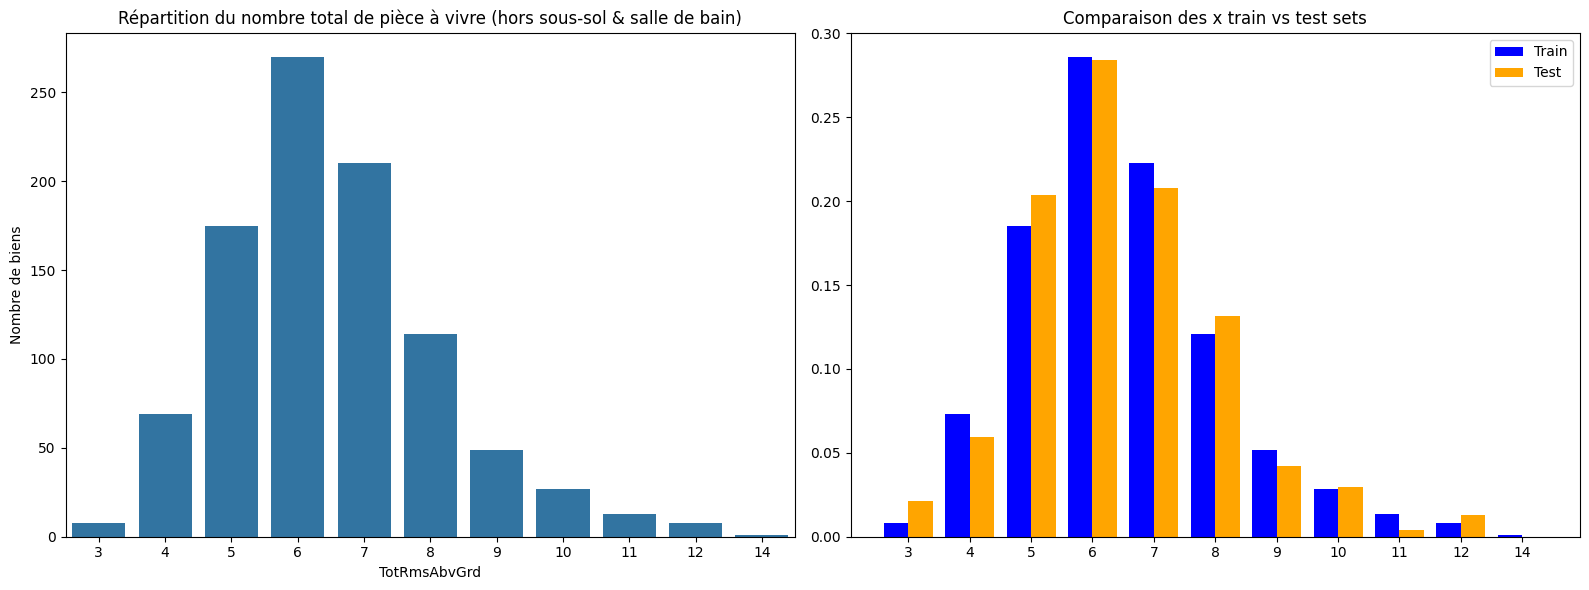

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=train, x="TotRmsAbvGrd", ax=ax1)
ax1.set_title("Répartition du nombre total de pièce à vivre (hors sous-sol & salle de bain)")
ax1.set_xlabel("TotRmsAbvGrd")
ax1.set_ylabel("Nombre de biens")

# Deuxième graphique : Comparaison des distributions entre train et test
train_counts = train['TotRmsAbvGrd'].value_counts(normalize=True).sort_index()
test_counts = test['TotRmsAbvGrd'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

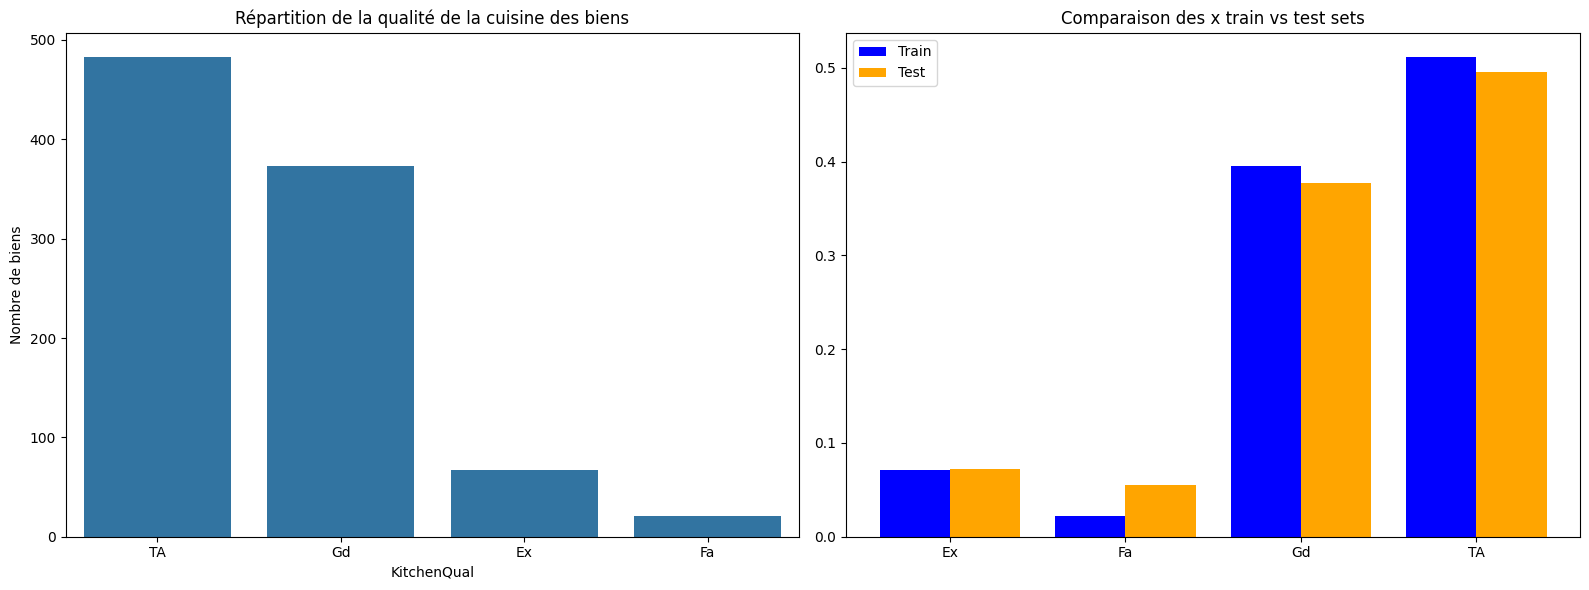

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=train, x="KitchenQual", ax=ax1)
ax1.set_title("Répartition de la qualité de la cuisine des biens")
ax1.set_xlabel("KitchenQual")
ax1.set_ylabel("Nombre de biens")

# Deuxième graphique : Comparaison des distributions entre train et test
train_counts = train['KitchenQual'].value_counts(normalize=True).sort_index()
test_counts = test['KitchenQual'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

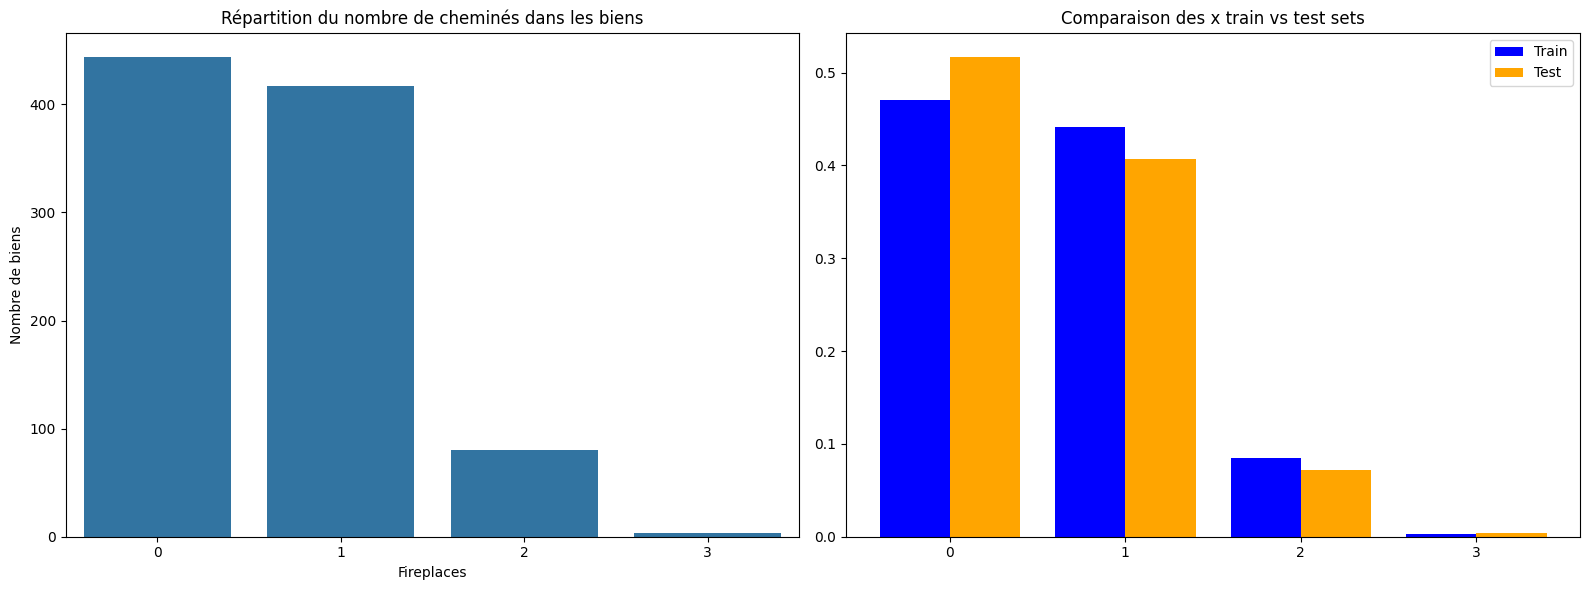

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=train, x="Fireplaces", ax=ax1)
ax1.set_title("Répartition du nombre de cheminés dans les biens")
ax1.set_xlabel("Fireplaces")
ax1.set_ylabel("Nombre de biens")

train_counts = train['Fireplaces'].value_counts(normalize=True).sort_index()
test_counts = test['Fireplaces'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

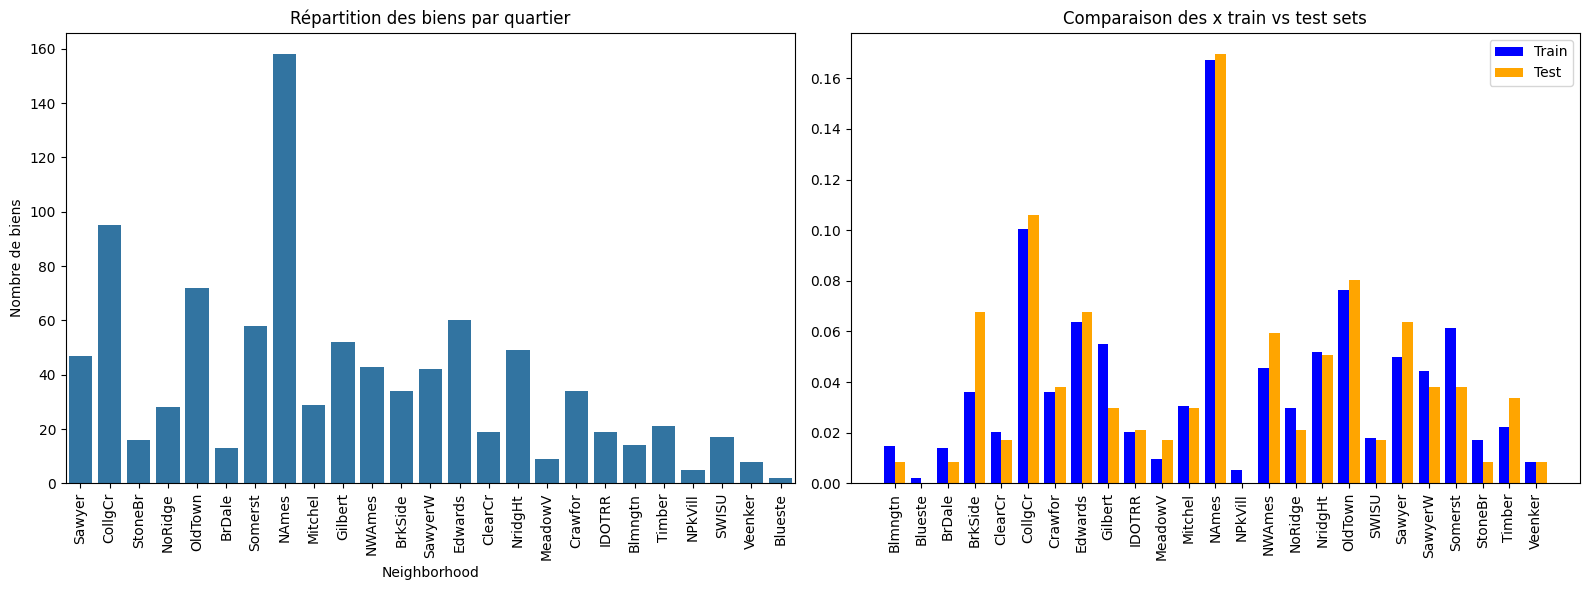

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=train, x="Neighborhood", ax=ax1)
ax1.set_title("Répartition des biens par quartier")
ax1.set_xlabel("Neighborhood")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel("Nombre de biens")

train_counts = train['Neighborhood'].value_counts(normalize=True).sort_index()
test_counts = test['Neighborhood'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories, rotation=90)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

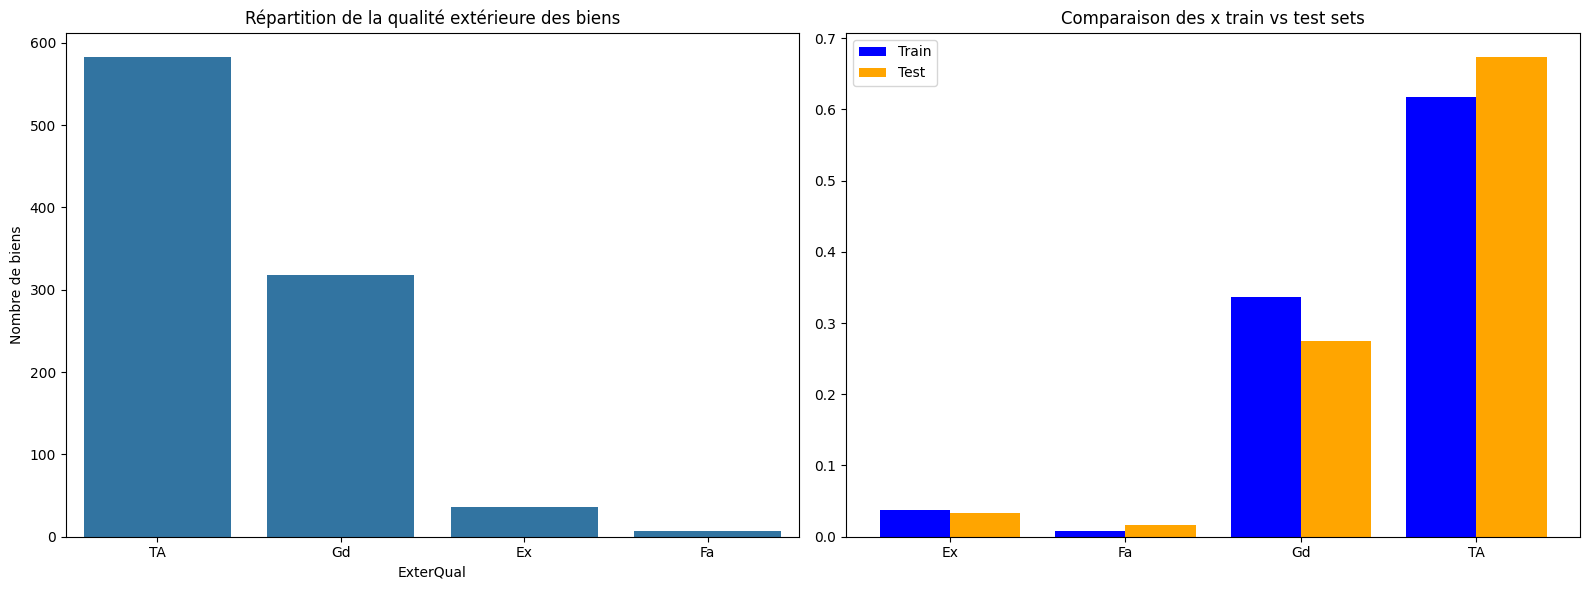

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=train, x="ExterQual", ax=ax1)
ax1.set_title("Répartition de la qualité extérieure des biens")
ax1.set_xlabel("ExterQual")
ax1.set_ylabel("Nombre de biens")

# Deuxième graphique : Comparaison des distributions entre train et test
train_counts = train['ExterQual'].value_counts(normalize=True).sort_index()
test_counts = test['ExterQual'].value_counts(normalize=True).sort_index()

categories = train_counts.index
x = range(len(categories))
width = 0.4

ax2.bar([i - width/2 for i in x], train_counts.values, width=width, label='Train', color='blue')
ax2.bar([i + width/2 for i in x], test_counts.reindex(categories, fill_value=0).values, width=width, label='Test', color='orange')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_title("Comparaison des x train vs test sets")
ax2.legend()

plt.tight_layout()
plt.show()

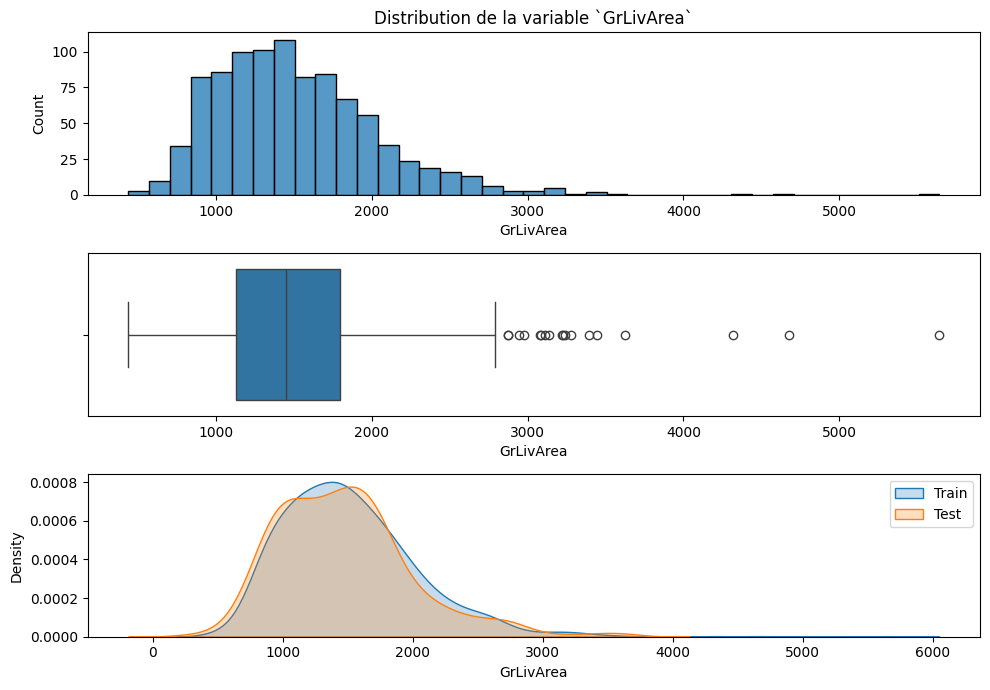

Skewness:  1.48
Kurtosis:  5.65


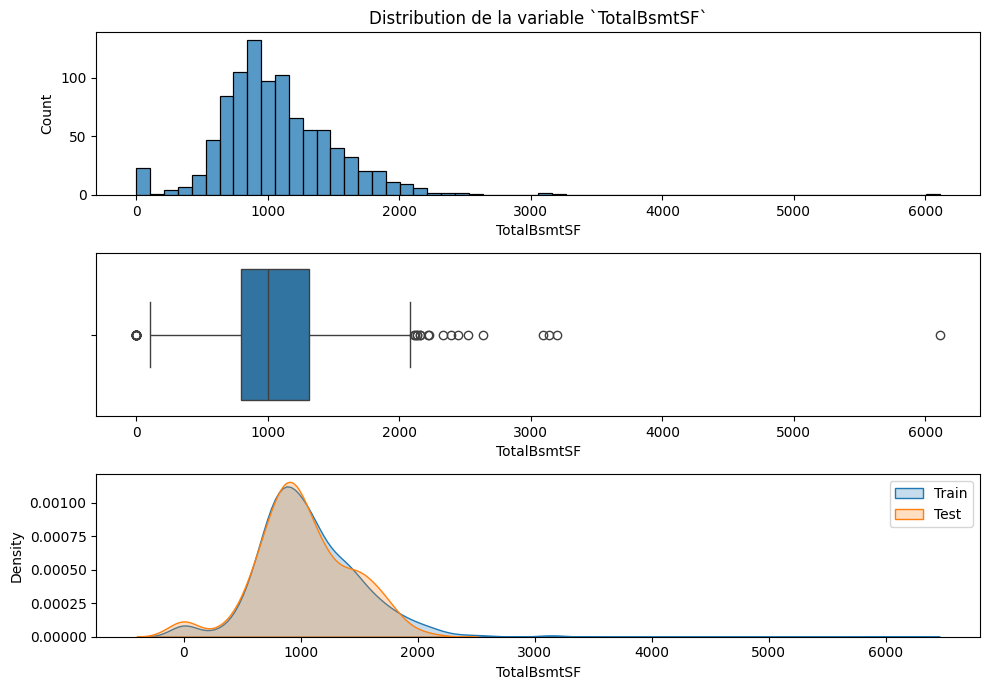

Skewness:  1.9
Kurtosis:  16.16


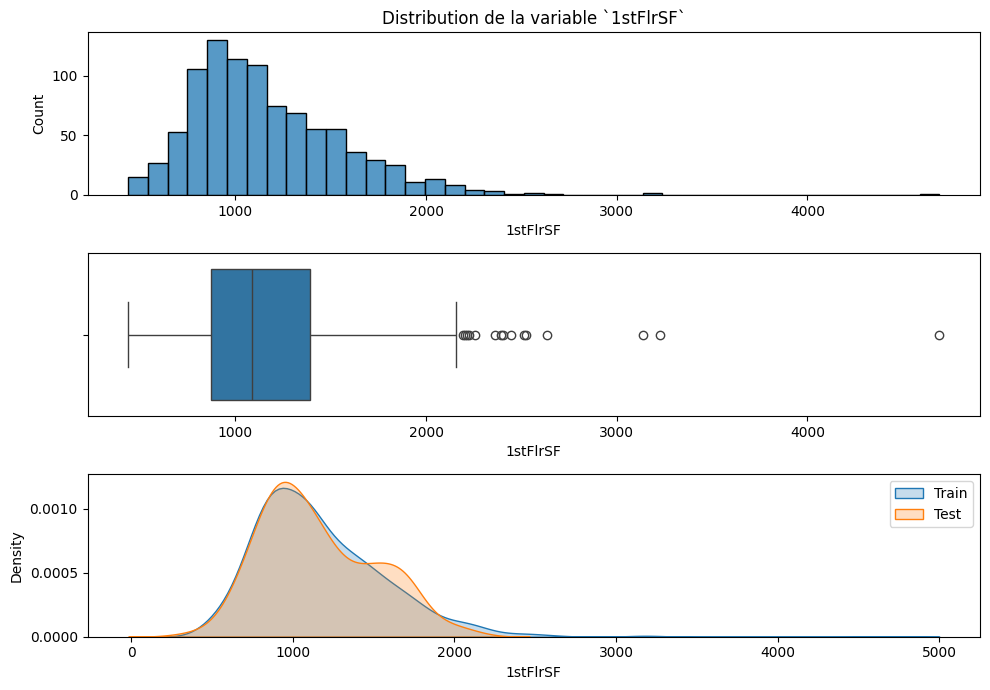

Skewness:  1.58
Kurtosis:  6.99


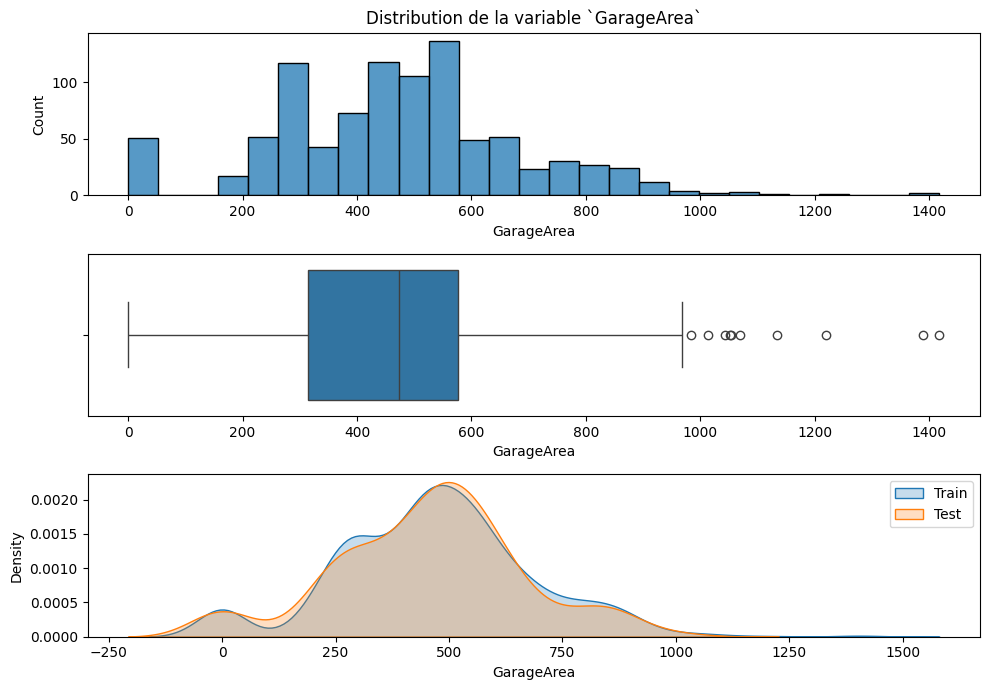

Skewness:  0.19
Kurtosis:  0.87


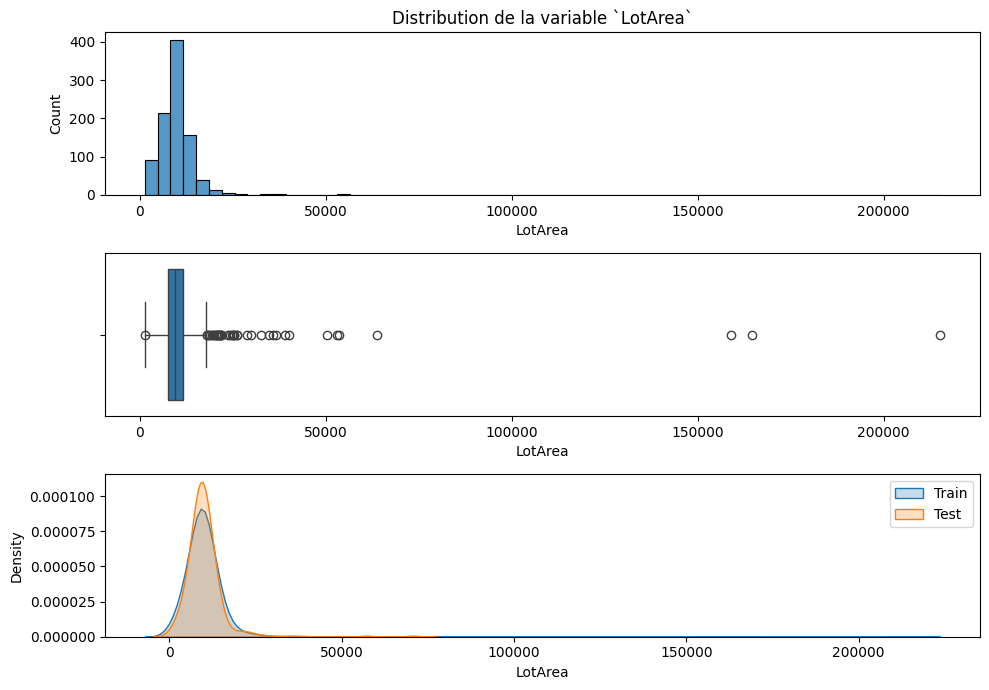

Skewness:  12.62
Kurtosis:  199.02


In [26]:
for col in continuous_columns:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,7))
    sns.histplot(data=train, x=col, ax=ax1)
    sns.boxplot(train, x=col, ax=ax2)
    sns.kdeplot(train, x=col, label='Train', shade=True, ax=ax3)
    sns.kdeplot(test, x=col, label='Test', shade=True, ax=ax3)
    ax1.set_title(f"Distribution de la variable `{col}`")
    ax3.legend()
    plt.tight_layout()
    plt.show()

    print('Skewness: ', round(stats.skew(train[col]), 2))
    print('Kurtosis: ', round(stats.kurtosis(train[col]), 2))



## Analyse multivarié

### Analyse des variables liés au bâtiment

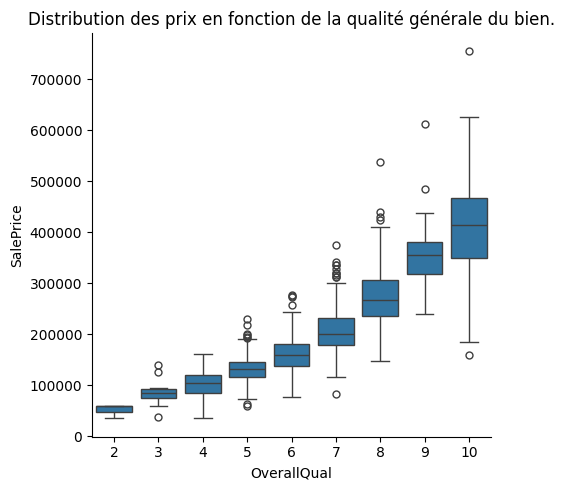

In [27]:
sns.catplot(data=train, x='OverallQual', y='SalePrice', kind='box')
plt.title("Distribution des prix en fonction de la qualité générale du bien.")
plt.tight_layout()
plt.show()

**Observations:** On semble observer une relation directe entre la qualité du biens et sont prix. Il faut maintenant le vérifier. Nous allons utiliser un test ANOVA pour s´assurer que la variance est différentes entre les différentes qualités.

In [28]:
# Critères:
# Les données doivent être normalement distribué dans chaque groupe ou au moins 30 points



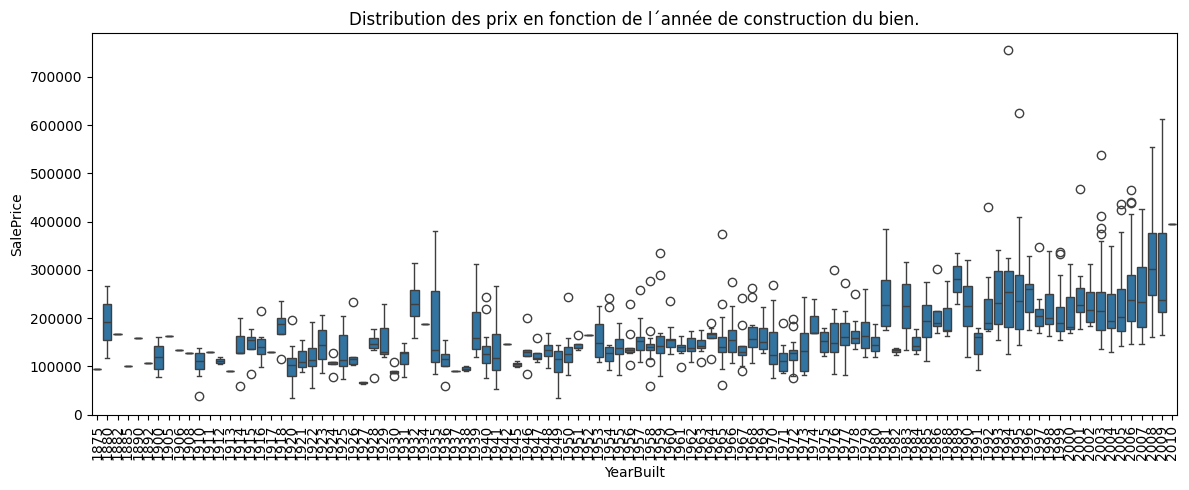

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='YearBuilt', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction de l´année de construction du bien.")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Analysons comment évolue le prix des biens plus la rénovation est proche de la production du dataset (2011).

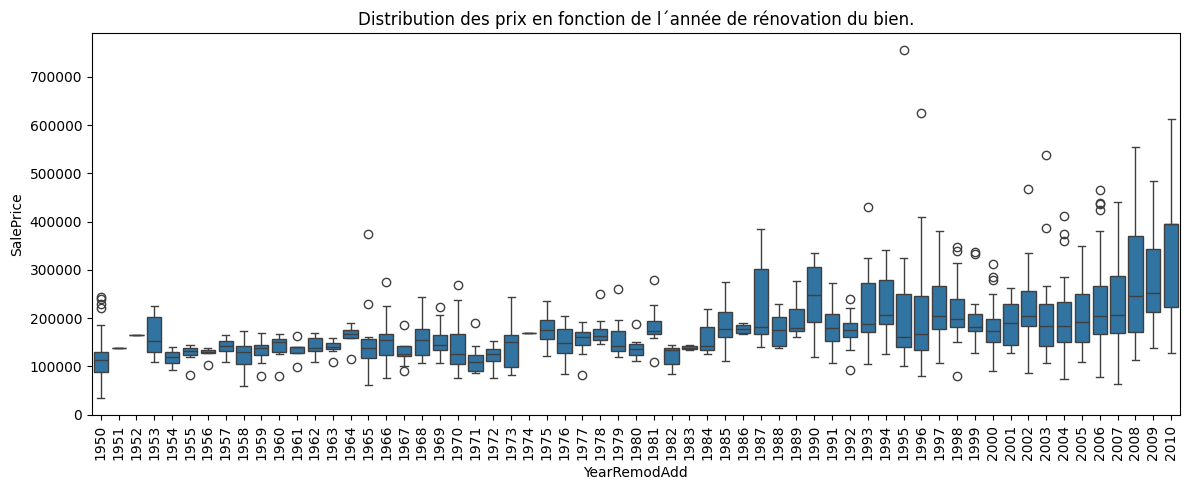

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='YearRemodAdd', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction de l´année de rénovation du bien.")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

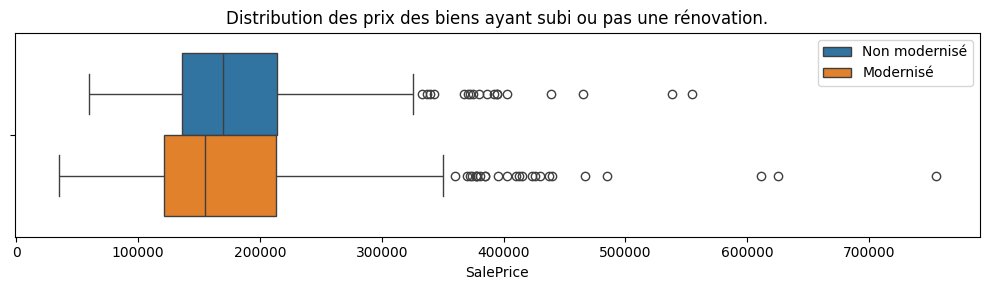

In [31]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=train, x='SalePrice', hue='HasRemod', ax=ax)
ax.set_title("Distribution des prix des biens ayant subi ou pas une rénovation.")
ax.legend(labels=['Non modernisé', 'Modernisé'])
plt.tight_layout()
plt.show()

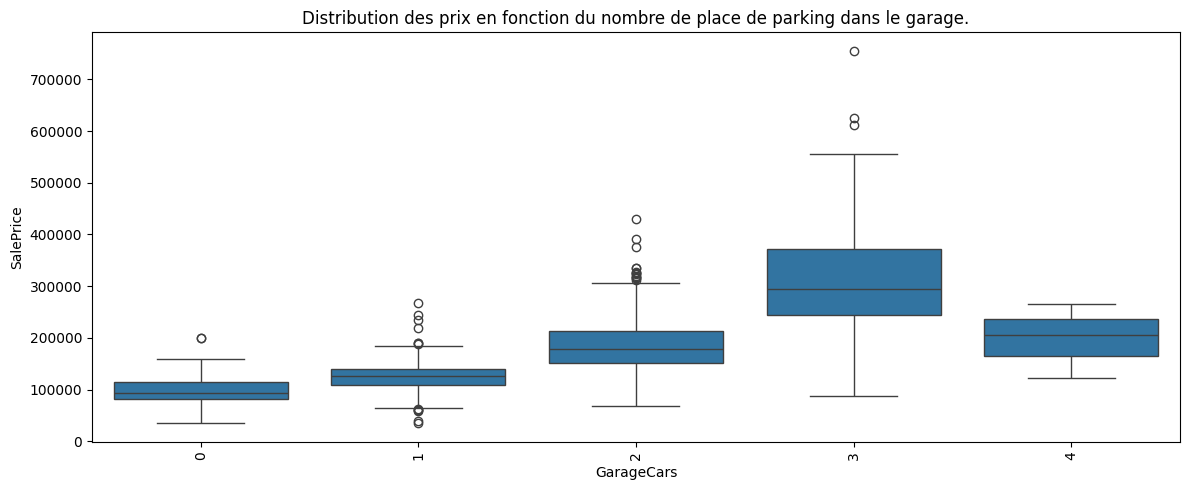

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='GarageCars', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction du nombre de place de parking dans le garage.")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

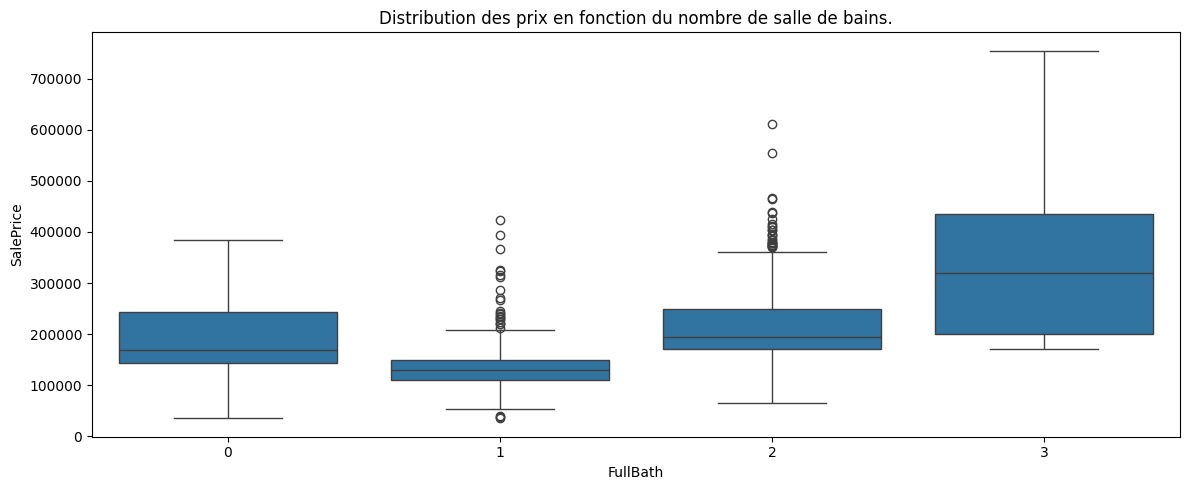

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='FullBath', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction du nombre de salle de bains.")
plt.tight_layout()
plt.show()

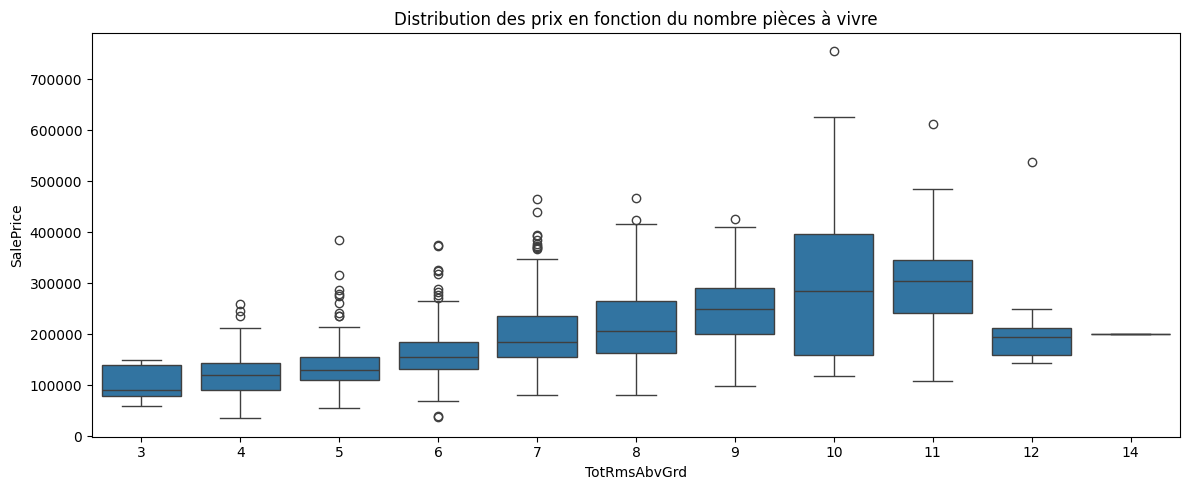

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='TotRmsAbvGrd', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction du nombre pièces à vivre")
plt.tight_layout()
plt.show()

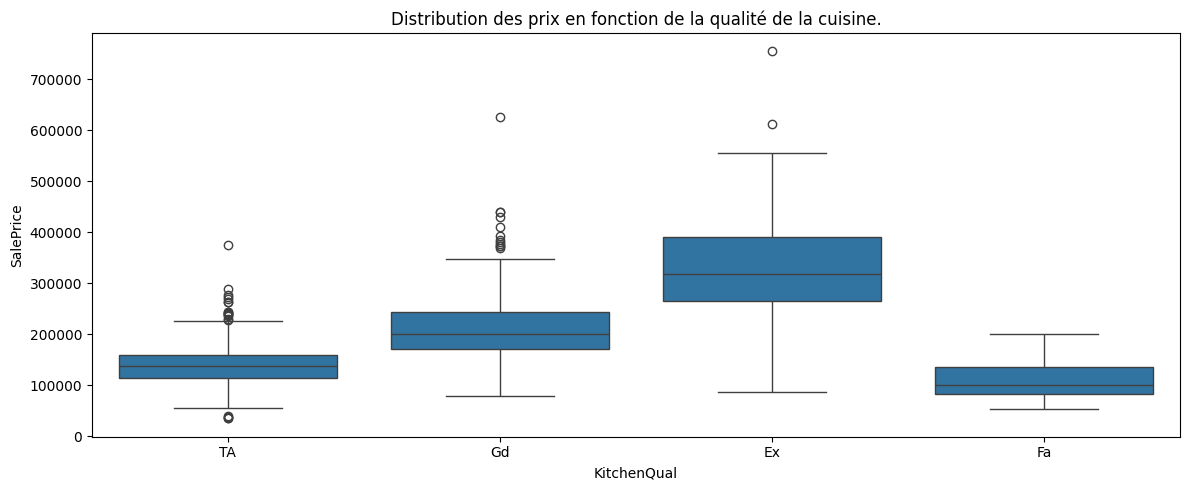

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='KitchenQual', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction de la qualité de la cuisine.")
plt.tight_layout()
plt.show()

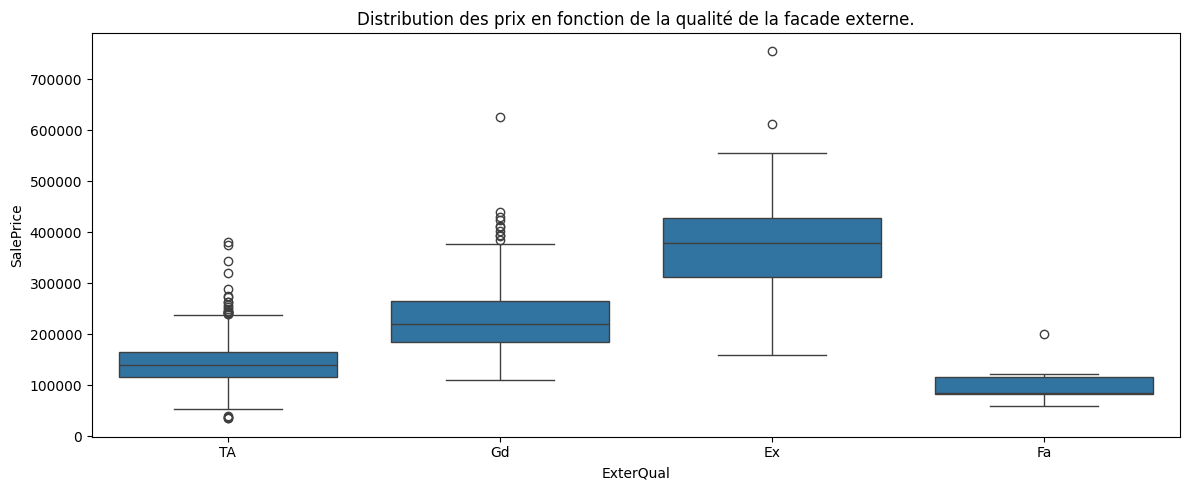

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='ExterQual', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction de la qualité de la facade externe.")
plt.tight_layout()
plt.show()

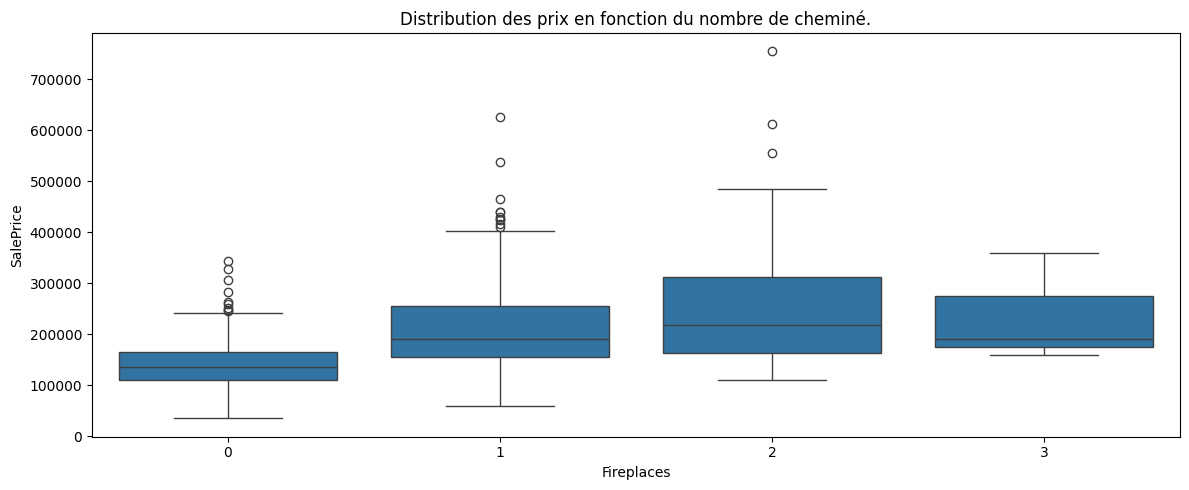

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='Fireplaces', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction du nombre de cheminé.")
plt.tight_layout()
plt.show()

In [38]:
samples = test.groupby('OverallQual')['SalePrice'].apply(list)

print("Test H₀ pour les variables liés au bâtiment:")
h0 = "Le prix du bien est identique pour tout niveau de qualité du bien."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

samples = test.query("`HasRemod` == True").groupby('YearRemodAdd')['SalePrice'].apply(list)

h0 = "Le prix des bien est identique quelque soit l´ancienneté de la rénovation."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

samples = test.groupby('YearRemodAdd')['SalePrice'].apply(list)
h0 = "Le prix des bien est identique quelque soit l´ancienneté de la dernière modernisation."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

mod = test.query("`HasRemod` == True")
no_mod = test.query("`HasRemod` == False")

h0 = "Le prix des bien modernisé et non modernisé sont en moyenne les mêmes."
p_value = stats.ttest_ind(mod['SalePrice'], no_mod['SalePrice']).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")


samples = test.groupby('GarageCars')['SalePrice'].apply(list)
h0 = "Le prix des bien est identique quelque soit le nombre de places de parking disponible."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

h0 = "Le prix des bien sans sdb est identique aux biens avec 1 sdb."
one_bath = test.query("`FullBath` == 1")
without_bath = test.query("`FullBath` == 0")

p_value = stats.ttest_ind(one_bath['SalePrice'], without_bath['SalePrice']).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

samples = test.groupby('TotRmsAbvGrd')['SalePrice'].apply(list)
h0 = "Le prix des bien est identique quelque soit le nombre de pièces à vivre."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

samples = test.groupby('ExterQual')['SalePrice'].apply(list)
h0 = "Le prix des bien est identique quelque soit la qualité de la facade."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

samples = test.groupby('KitchenQual')['SalePrice'].apply(list)
h0 = "Le prix des bien est identique quelque soit la qualité de la cuisine."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

samples = test.groupby('Fireplaces')['SalePrice'].apply(list)
h0 = "Le prix des bien est identique quelque soit le nombre de cheminé."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

Test H₀ pour les variables liés au bâtiment:
Le prix du bien est identique pour tout niveau de qualité du bien.------------------------ H₀ rejetée
Le prix des bien est identique quelque soit l´ancienneté de la rénovation.---------------- H₀ rejetée
Le prix des bien est identique quelque soit l´ancienneté de la dernière modernisation.---- H₀ rejetée
Le prix des bien modernisé et non modernisé sont en moyenne les mêmes.-------------------- '-'
Le prix des bien est identique quelque soit le nombre de places de parking disponible.---- H₀ rejetée
Le prix des bien sans sdb est identique aux biens avec 1 sdb.----------------------------- '-'
Le prix des bien est identique quelque soit le nombre de pièces à vivre.------------------ H₀ rejetée
Le prix des bien est identique quelque soit la qualité de la facade.---------------------- H₀ rejetée
Le prix des bien est identique quelque soit la qualité de la cuisine.--------------------- H₀ rejetée
Le prix des bien est identique quelque soit le nomb

In [39]:
from sklearn import set_config
from sklearn.preprocessing import OrdinalEncoder
set_config(transform_output = "pandas")

# Encodons les features de qualité
quality_order = ['Fa', 'TA', 'Gd', 'Ex']
encoder = OrdinalEncoder(categories=[quality_order,])
train[["ExterQual"]] = encoder.fit_transform(train[["ExterQual"]])
train[["KitchenQual"]] = encoder.fit_transform(train[["KitchenQual"]])

### Analyse des variables liés à l´espace

In [40]:
large_property_index = train[(train.GrLivArea > 4500) | (train.LotArea >150_000)].index.to_list()

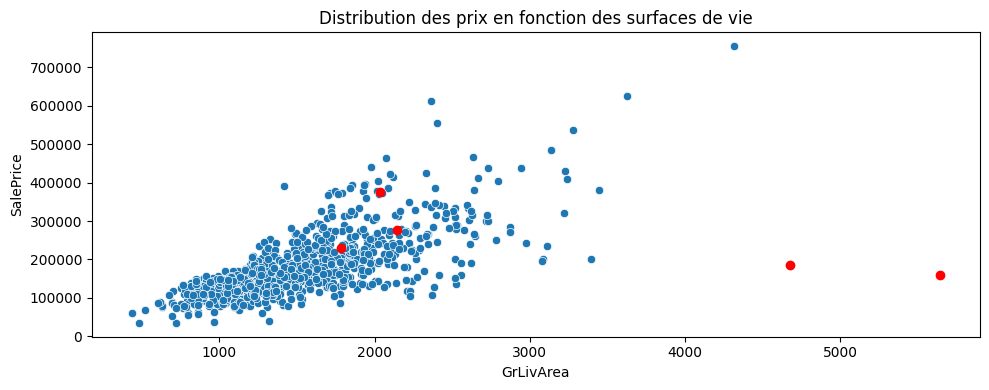

In [41]:
fig, ax = plt.subplots(figsize=(10,4))
sns.scatterplot(data=train, x="GrLivArea", y="SalePrice", ax=ax)
highlight = train.loc[large_property_index]
ax.scatter(highlight["GrLivArea"], highlight["SalePrice"], color="red")
ax.set_title("Distribution des prix en fonction des surfaces de vie")
plt.tight_layout()
plt.show()

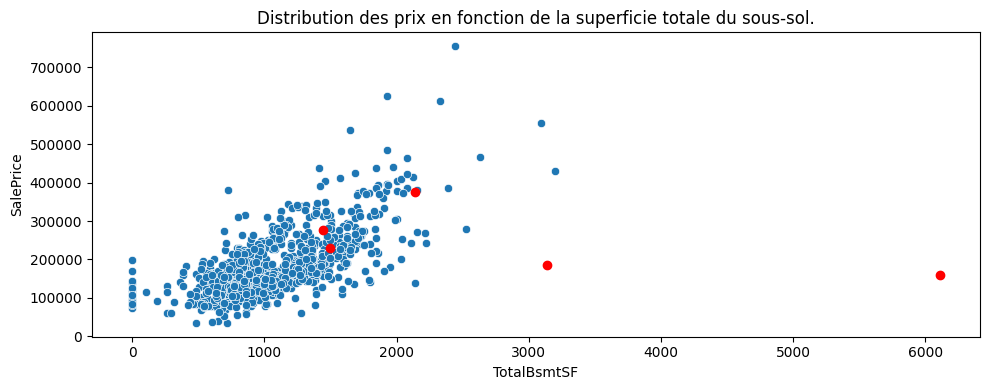

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=train, x="TotalBsmtSF", y="SalePrice", ax=ax)
highlight = train.loc[large_property_index]
ax.scatter(highlight["TotalBsmtSF"], highlight["SalePrice"], color="red", label="Highlighted Points")
ax.set_title("Distribution des prix en fonction de la superficie totale du sous-sol.")
plt.tight_layout()
plt.show()

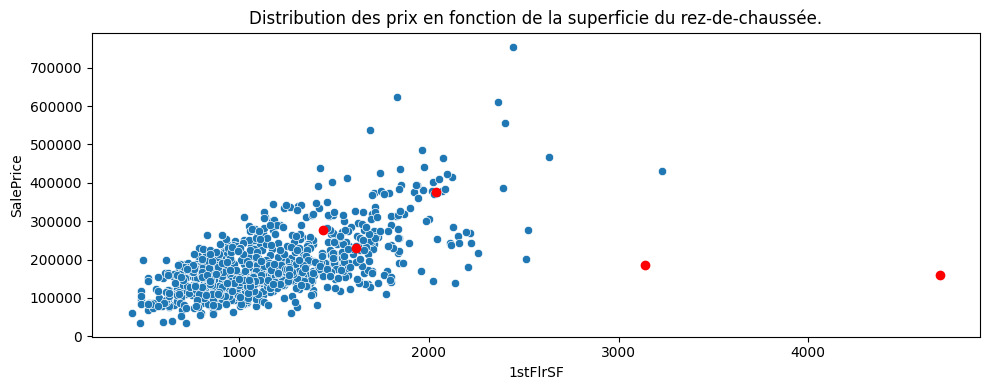

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=train, x="1stFlrSF", y="SalePrice", ax=ax)
highlight = train.loc[large_property_index]
ax.scatter(highlight["1stFlrSF"], highlight["SalePrice"], color="red", label="Highlighted Points")
ax.set_title("Distribution des prix en fonction de la superficie du rez-de-chaussée.")
plt.tight_layout()
plt.show()

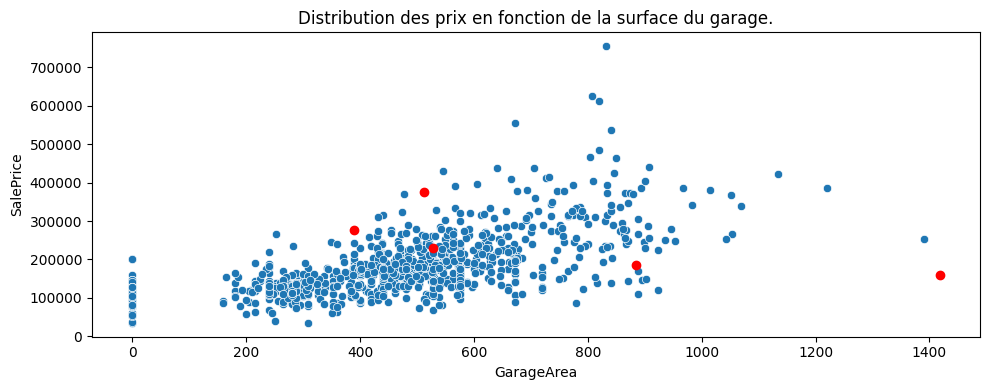

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=train, x="GarageArea", y="SalePrice", ax=ax)
highlight = train.loc[large_property_index]
ax.scatter(highlight["GarageArea"], highlight["SalePrice"], color="red", label="Highlighted Points")
ax.set_title("Distribution des prix en fonction de la surface du garage.")
plt.tight_layout()
plt.show()

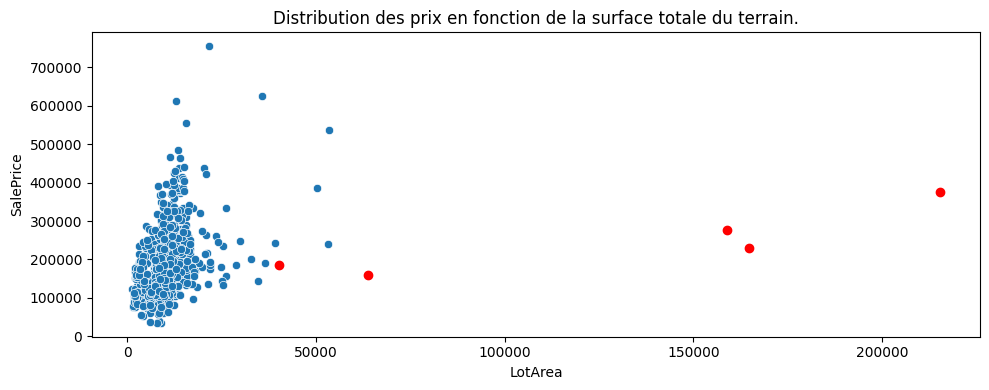

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=train, x="LotArea", y="SalePrice", ax=ax)
highlight = train.loc[large_property_index]
ax.scatter(highlight["LotArea"], highlight["SalePrice"], color="red", label="Highlighted Points")
ax.set_title("Distribution des prix en fonction de la surface totale du terrain.")
plt.tight_layout()
plt.show()

<Axes: >

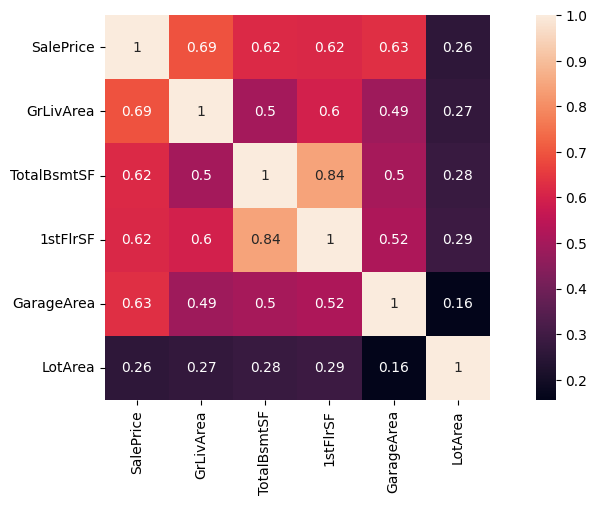

In [46]:
corrmat = train[['SalePrice', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'LotArea']].corr()
f, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(corrmat, square=True, annot=True)

### Analyse des variables liés à l´emplacement

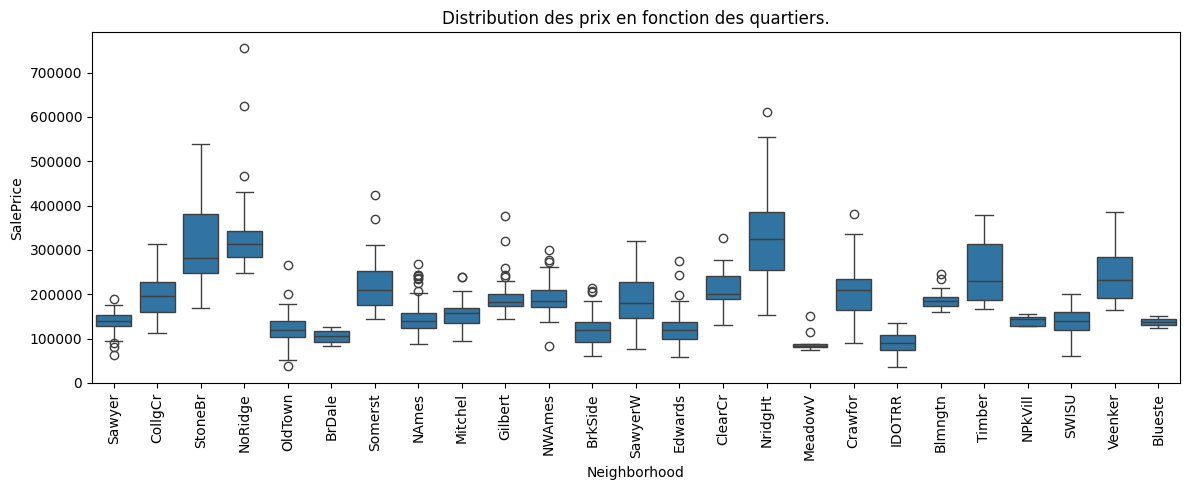

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='Neighborhood', y='SalePrice', ax=ax)
ax.set_title("Distribution des prix en fonction des quartiers.")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [48]:
print("Test H₀ pour les variables liés à l´emplacement:")

samples = test.groupby('Neighborhood')['SalePrice'].apply(list)
h0 = "Le prix des bien est identique quelque soit le quartier."
p_value = stats.f_oneway(*samples).pvalue
if p_value < ALPHA:
    print(f'{h0 :-<90} H₀ rejetée')
else :
    print(f"{h0 :-<90} '-'")

Test H₀ pour les variables liés à l´emplacement:
Le prix des bien est identique quelque soit le quartier.---------------------------------- H₀ rejetée


In [49]:
neighborhood_order = train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=True).index.to_list()
encoder = OrdinalEncoder(categories=[neighborhood_order,])
train[['Neighborhood']] = encoder.fit_transform(train[['Neighborhood']])

print("Ordre des voisinage:", neighborhood_order)


Ordre des voisinage: ['MeadowV', 'IDOTRR', 'BrDale', 'Edwards', 'BrkSide', 'OldTown', 'Blueste', 'Sawyer', 'SWISU', 'NAmes', 'NPkVill', 'Mitchel', 'SawyerW', 'Gilbert', 'Blmngtn', 'NWAmes', 'CollgCr', 'ClearCr', 'Crawfor', 'Somerst', 'Timber', 'Veenker', 'StoneBr', 'NoRidge', 'NridgHt']


<Axes: >

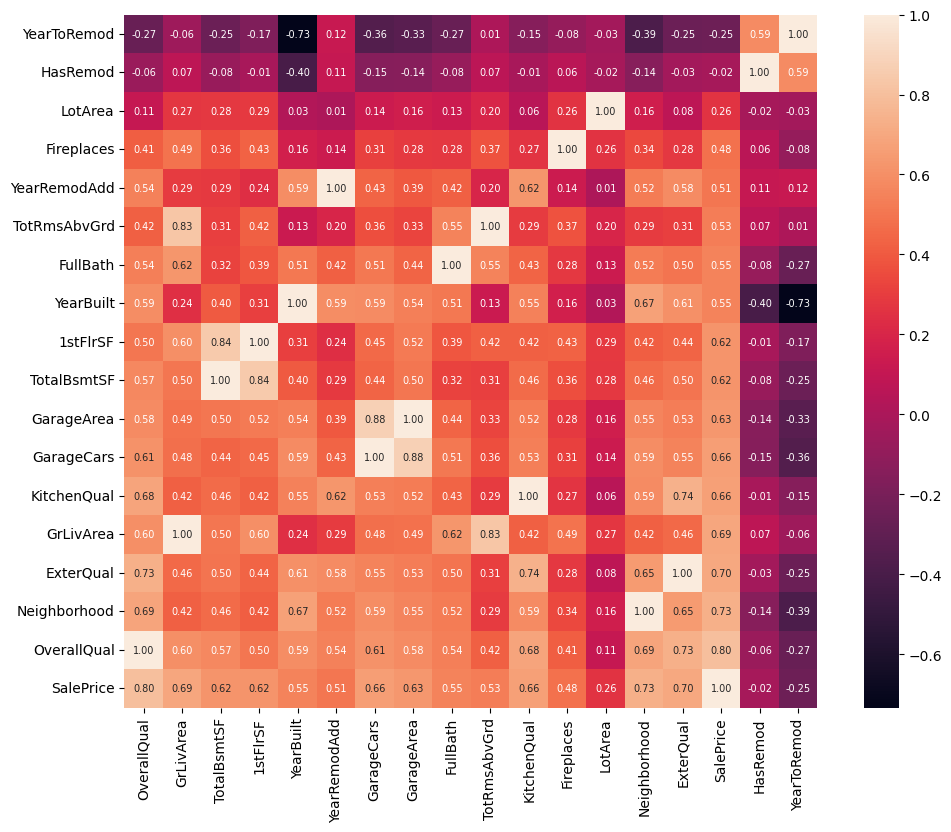

In [50]:
corrmat = train.corr().sort_values(by='SalePrice')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', annot_kws={'size': 7})

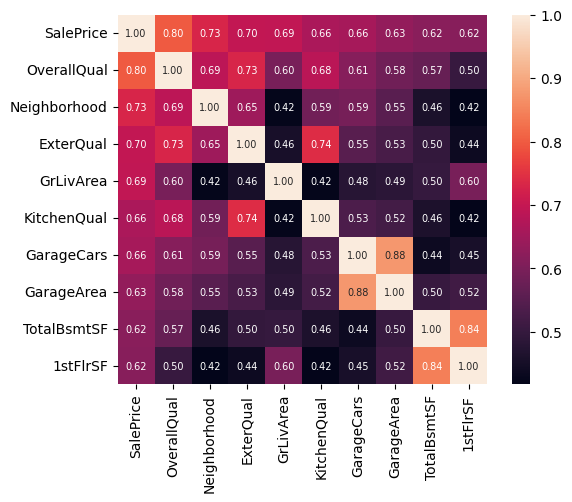

In [51]:
import numpy as np


k = 10 #nombre de variables pour la carte thermique
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Feature Engineering

Skewness:  nan
Kurtosis:  nan


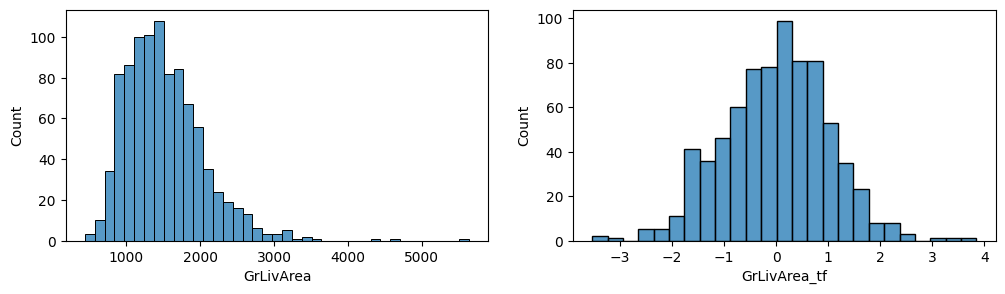

In [52]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method='yeo-johnson')
train['GrLivArea_tf'] = transformer.fit_transform(train.GrLivArea.to_numpy().reshape(-1,1))
scaler = StandardScaler()
train['GrLivArea_tf'] = scaler.fit_transform(train[['GrLivArea_tf']])



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.histplot(train, x='GrLivArea', ax=ax1)
sns.histplot(train, x='GrLivArea_tf', ax=ax2)

print('Skewness: ', round(stats.skew(train['GrLivArea_tf']), 2))
print('Kurtosis: ', round(stats.kurtosis(train['GrLivArea_tf']), 2))

Skewness:  nan
Kurtosis:  nan


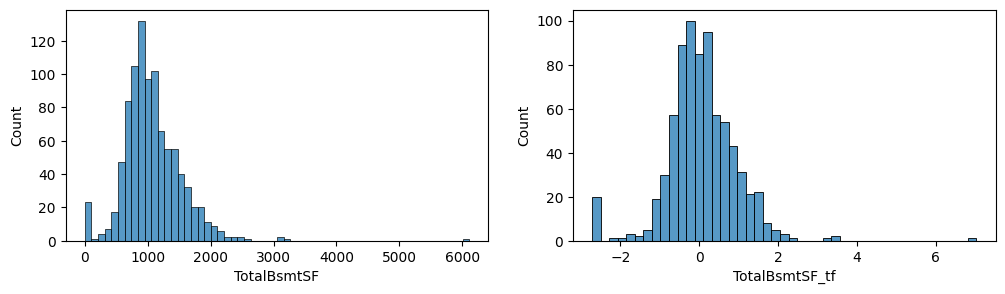

In [53]:
from sklearn.preprocessing import RobustScaler


transformer = PowerTransformer(method='yeo-johnson')
train['TotalBsmtSF_tf'] = transformer.fit_transform(train.TotalBsmtSF.to_numpy().reshape(-1,1))
scaler = RobustScaler()
train['TotalBsmtSF_tf'] = scaler.fit_transform(train[['TotalBsmtSF_tf']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.histplot(train, x='TotalBsmtSF', ax=ax1)
sns.histplot(train, x='TotalBsmtSF_tf', ax=ax2)

print('Skewness: ', round(stats.skew(train['TotalBsmtSF_tf']), 2))
print('Kurtosis: ', round(stats.kurtosis(train['TotalBsmtSF_tf']), 2))

Skewness:  nan
Kurtosis:  nan


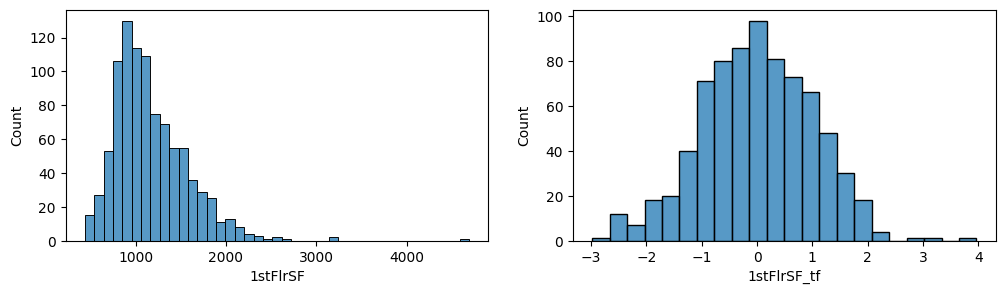

In [54]:
transformer = PowerTransformer(method='yeo-johnson')
train['1stFlrSF_tf'] = transformer.fit_transform(train['1stFlrSF'].to_numpy().reshape(-1,1))
scaler = StandardScaler()
train['1stFlrSF_tf'] = scaler.fit_transform(train[['1stFlrSF_tf']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.histplot(train, x='1stFlrSF', ax=ax1)
sns.histplot(train, x='1stFlrSF_tf', ax=ax2)

print('Skewness: ', round(stats.skew(train['1stFlrSF_tf']), 2))
print('Kurtosis: ', round(stats.kurtosis(train['1stFlrSF_tf']), 2))

Skewness:  nan
Kurtosis:  nan


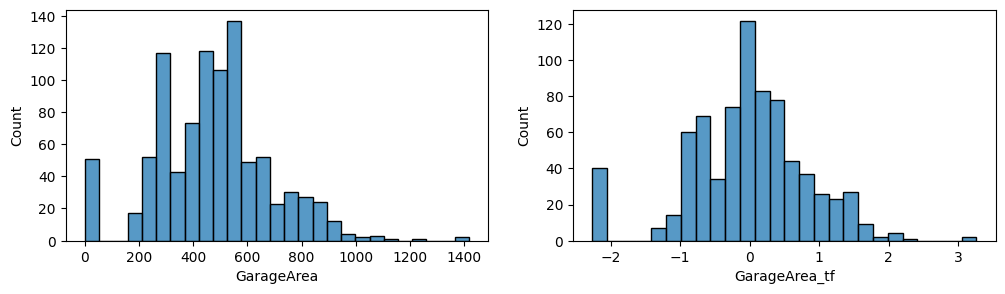

In [55]:
transformer = PowerTransformer(method='yeo-johnson')
train['GarageArea_tf'] = transformer.fit_transform(train.GarageArea.to_numpy().reshape(-1,1))
scaler = RobustScaler()
train['GarageArea_tf'] = scaler.fit_transform(train[['GarageArea_tf']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.histplot(train, x='GarageArea', ax=ax1)
sns.histplot(train, x='GarageArea_tf', ax=ax2)

print('Skewness: ', round(stats.skew(train['GarageArea_tf']), 2))
print('Kurtosis: ', round(stats.kurtosis(train['GarageArea_tf']), 2))

Skewness:  nan
Kurtosis:  nan


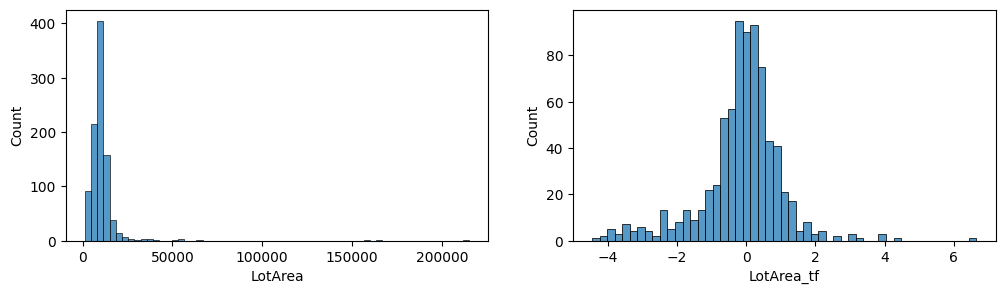

In [63]:
transformer = PowerTransformer(method='yeo-johnson')
train['LotArea_tf'] = transformer.fit_transform(train.LotArea.to_numpy().reshape(-1,1))
scaler = RobustScaler()
train['LotArea_tf'] = scaler.fit_transform(train[['LotArea_tf']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.histplot(train, x='LotArea', ax=ax1)
sns.histplot(train, x='LotArea_tf', ax=ax2)

print('Skewness: ', round(stats.skew(train['LotArea_tf']), 2))
print('Kurtosis: ', round(stats.kurtosis(train['LotArea_tf']), 2))

Skewness:  nan
Kurtosis:  nan


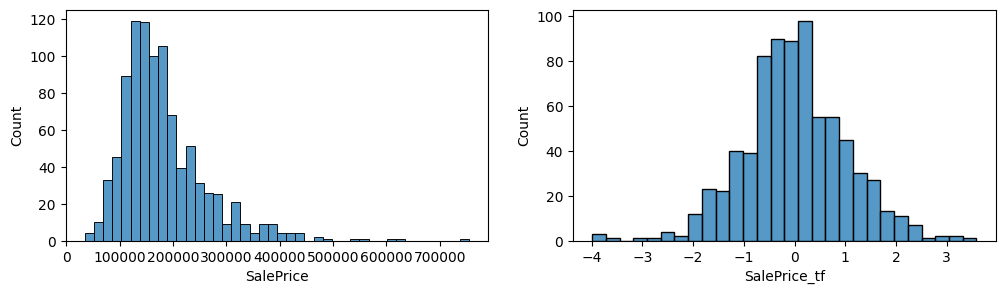

In [64]:
target_transformer = PowerTransformer(method='yeo-johnson')
train['SalePrice_tf'] = target_transformer.fit_transform(train.SalePrice.to_numpy().reshape(-1,1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
sns.histplot(train, x='SalePrice', ax=ax1)
sns.histplot(train, x='SalePrice_tf', ax=ax2)

print('Skewness: ', round(stats.skew(train['SalePrice_tf']), 2))
print('Kurtosis: ', round(stats.kurtosis(train['SalePrice_tf']), 2))

Le fait de transformer la target par une transformation log permet de retrouver la corrélation linéaire avec les features d´espace. La corrélation avec les features discrètes comme `YearBuilt`, `KitchenQual` en est affecté car les moyennes de chaque catégorie en est resserré mais reste valable...

<Axes: >

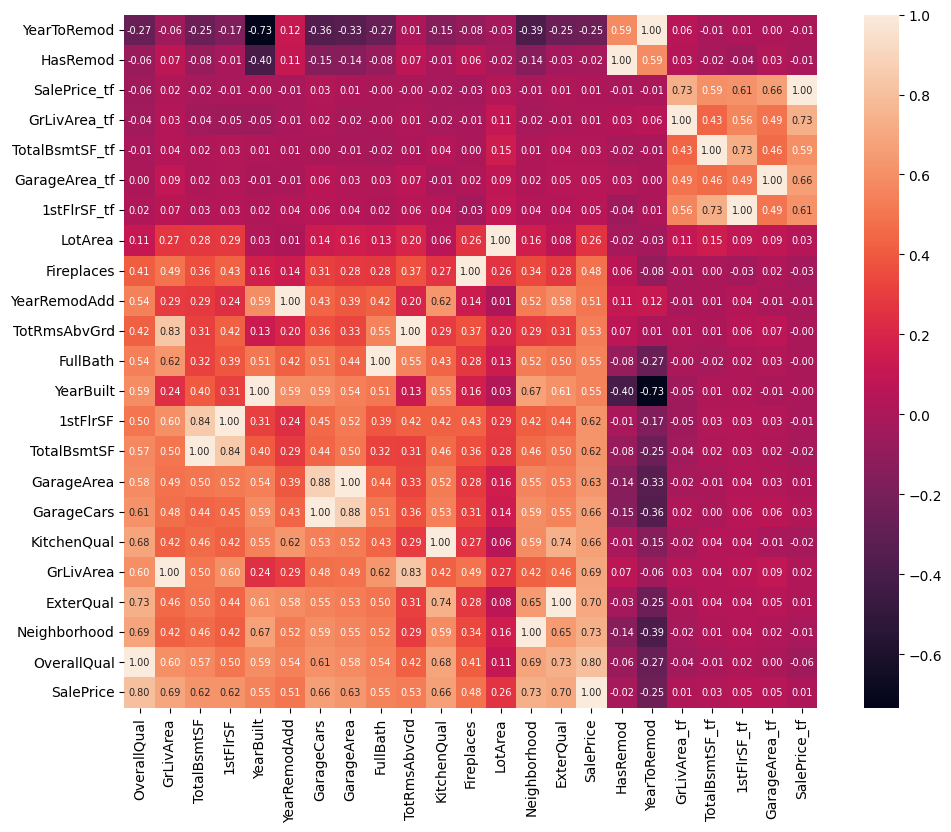

In [59]:
corrmat = train.corr().sort_values(by='SalePrice')
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', annot_kws={'size': 7})

In [99]:
train.columns

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt',
       'YearRemodAdd', 'GarageCars', 'GarageArea', 'FullBath', 'TotRmsAbvGrd',
       'KitchenQual', 'Fireplaces', 'LotArea', 'Neighborhood', 'ExterQual',
       'SalePrice', 'HasRemod', 'YearToRemod', 'GrLivArea_tf',
       'TotalBsmtSF_tf', '1stFlrSF_tf', 'GarageArea_tf', 'LotArea_tf',
       'SalePrice_tf'],
      dtype='object')

In [113]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

keep_columns = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea']

data = train.loc[:, keep_columns]

iso = IsolationForest(random_state=RANDOM_STATE, contamination=0.03)
outlier_predictions = iso.fit_predict(data)
inlier_mask = outlier_predictions == 1
outlier_mask = outlier_predictions == -1

normal_data_iso = train.loc[inlier_mask]
outliers_iso = train.loc[outlier_mask]

lof = LocalOutlierFactor(contamination=0.03)
outlier_predictions = lof.fit_predict(data)
inlier_mask = outlier_predictions == 1
outlier_mask = outlier_predictions == -1

normal_data_lof = train.loc[inlier_mask]
outliers_lof = train.loc[outlier_mask]



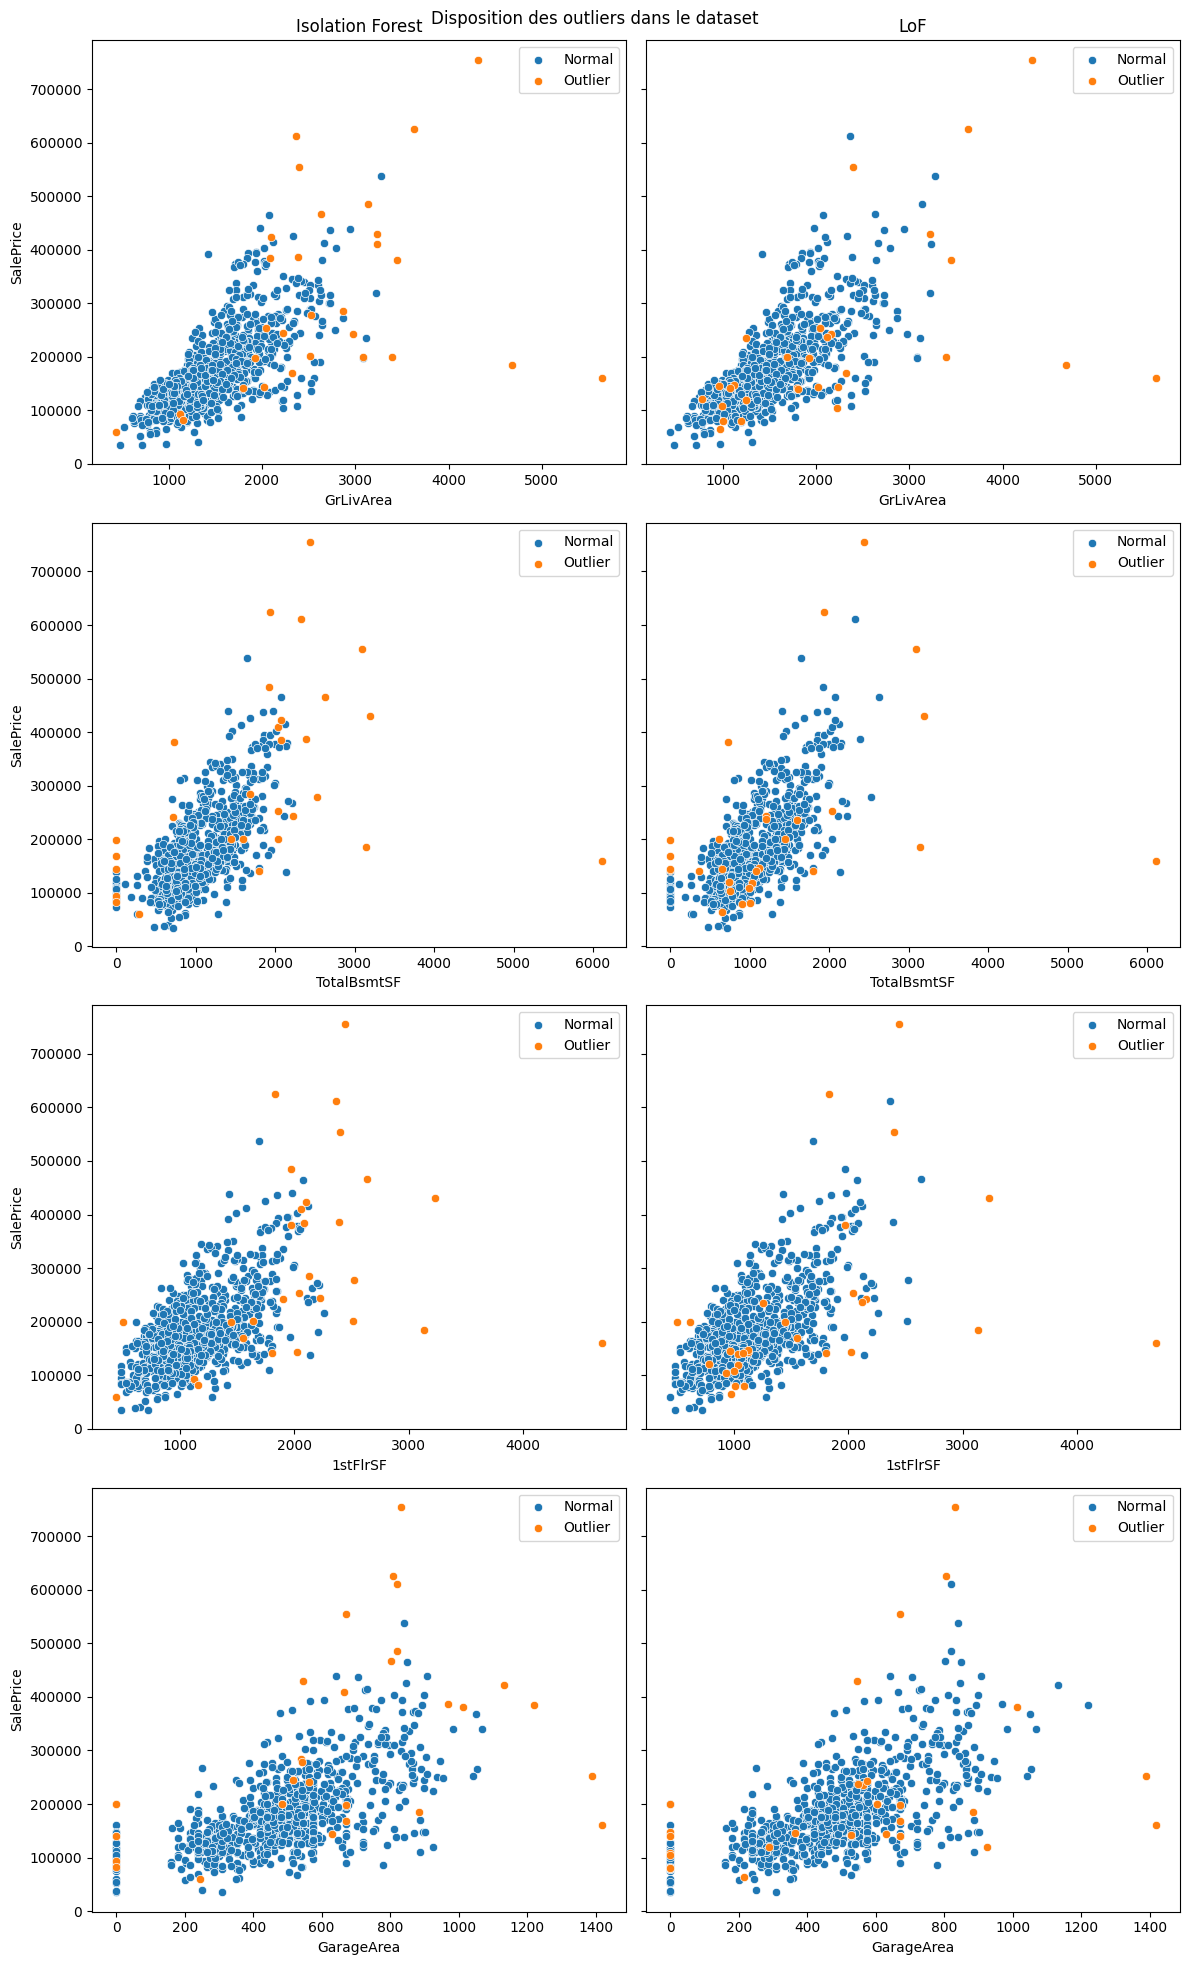

In [126]:
# Visualisation simple
fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)
for i, name in enumerate(keep_columns):
    sns.scatterplot(data=normal_data_iso, x=name, y="SalePrice", ax=ax[i, 0], label="Normal")
    sns.scatterplot(data=outliers_iso, x=name, y="SalePrice", ax=ax[i, 0], label="Outlier")
    
    sns.scatterplot(data=normal_data_lof, x=name, y="SalePrice", ax=ax[i, 1], label="Normal")
    sns.scatterplot(data=outliers_lof, x=name, y="SalePrice", ax=ax[i, 1], label="Outlier")
fig.suptitle("Disposition des outliers dans le dataset")
ax[0, 0].set_title("Isolation Forest")
ax[0, 1].set_title("LoF")
fig.suptitle("Disposition des outliers dans le dataset")
plt.tight_layout()
plt.show()